### Importing Libraries

In [1]:
import ast
import warnings
from collections import Counter
from itertools import chain

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.display import clear_output
from ipywidgets import interact, widgets
from scipy import stats
from scipy.stats import f_oneway, pearsonr, spearmanr
from statsmodels.formula.api import ols
from tabulate import tabulate

from src.utils.plot_utils import revenue_formatter

warnings.filterwarnings("ignore")
%matplotlib inline
# auto-reload modules
%load_ext autoreload
%autoreload 2

### Loading the Dataset

In [2]:
# load the dataset
PATH = "data/processed/movies_processed.csv"
df = pd.read_csv(PATH)

df.head()

wiki_movie_id freebase_movie_id                movie_name  \
0         975900         /m/03vyhn            Ghosts of Mars   
1       10408933        /m/02qc0j7  Alexander's Ragtime Band   
2         171005         /m/016ywb                   Henry V   
3          77856          /m/0kcn7              Mary Poppins   
4         612710         /m/02wjqm            New Rose Hotel   

  movie_release_date  movie_box_office_revenue  movie_runtime  \
0         2001-08-24                14010832.0           98.0   
1         1938-08-16                 3600000.0          106.0   
2         1989-11-08                10161099.0          137.0   
3         1964-08-27               102272727.0          139.0   
4         1999-10-01                   21521.0           92.0   

                        movie_languages  \
0  [('/m/02h40lc', 'English Language')]   
1  [('/m/02h40lc', 'English Language')]   
2  [('/m/02h40lc', 'English Language')]   
3  [('/m/02h40lc', 'English Language')]   
4  [('/m/02h40lc', 'English Language')]   

                               movie_countries  \
0  [('/m/09c7w0', 'United States of America')]   
1  [('/m/09c7w0', 'United States of America')]   
2             [('/m/07ssc', 'United Kingdom')]   
3  [('/m/09c7w0', 'United States of America')]   
4  [('/m/09c7w0', 'United States of America')]   

                                        movie_genres  release_year  ...  \
0  [('/m/01jfsb', 'Thriller'), ('/m/06n90', 'Scie...        2001.0  ...   
1  [('/m/04t36', 'Musical'), ('/m/01z4y', 'Comedy...        1938.0  ...   
2  [('/m/04xvh5', 'Costume drama'), ('/m/082gq', ...        1989.0  ...   
3  [('/m/0hj3myq', "Children's/Family"), ('/m/04t...        1964.0  ...   
4  [('/m/01jfsb', 'Thriller'), ('/m/06n90', 'Scie...        1999.0  ...   

     imdb_id  combined_revenue release_month  release_day  \
0  tt0228333        14010832.0           8.0         24.0   
1  tt0029852         4000000.0           8.0         16.0   
2  tt0097499        10161099.0          11.0          8.0   
3  tt0058331       102272727.0           8.0         27.0   
4        NaN           21521.0          10.0          1.0   

               primaryTitle  startYear averageRating  numVotes  \
0            Ghosts of Mars     2001.0           4.9   58868.0   
1  Alexander's Ragtime Band     1938.0           6.8    2357.0   
2                   Henry V     1989.0           7.5   32088.0   
3              Mary Poppins     1964.0           7.8  189183.0   
4                       NaN        NaN           0.0       0.0   

           director  inflated_revenue  
0    John Carpenter      1.899115e+07  
1        Henry King      6.812740e+07  
2   Kenneth Branagh      1.967252e+07  
3  Robert Stevenson      7.913870e+08  
4           Unknown      3.100822e+04  

[5 rows x 22 columns]

# Movie 1: Echo 📢 
## How does a movie’s IMDb rating relate to its box office success?

</div> <div class="alert alert-success"> 🎞️ <strong>Movie Trailer:</strong>

The film industry is a complex ecosystem where various factors contribute to a movie’s success. Among these factors, audience reception and financial performance are two critical metrics. This analysis aims to explore the relationship between a movie’s IMDb rating—a reflection of audience and critic reception—and its box office revenue. Understanding this relationship can provide valuable insights for filmmakers, producers, investors as well as researchers such as ourselves.

**🏗️ Analysis Structure:**

- **Data Preparation**
  - Relevant columns
  - Handling missing values
  - Handling duplicates
  - ...
- **Exploratory Data Analysis**
  - Summary statistics
  - Number of movies per genre
  - Distribution of IMDb ratings
  - Distribution of box office revenue
  - ...
- **Regression Analysis**
  - ...
- ...


</div>

### Data Preparation

#### Relevant Columns
For this analysis, we’ll focus on the following columns:
*	`averageRating`: The IMDb rating of the movie.
*	`inflated_revenue`: The box office revenue adjusted for inflation.
*	`numVotes`: The number of votes the movie received on IMDb.
*   `movie_genres`: The genres of the movie.

In [3]:
# Select relevant columns
df_rating = df[
    ["movie_name", "averageRating", "inflated_revenue", "numVotes", "movie_genres"]
]

#### Handling Missing Values
We’ll check and remove the rows that contains no votes or revenue information.

In [4]:
# Drop rows with missing values or zero numVotes
df_rating.dropna(
    subset=["averageRating", "inflated_revenue", "numVotes"],
    inplace=True,
)
df_rating = df_rating[df_rating.numVotes > 0]

#### Handling Duplicates

In [5]:
# Check for duplicates
df_rating.duplicated().sum()

# remove duplicates if any
df_rating.drop_duplicates(inplace=True)

In [6]:
# Split genres into a list of genres names
df_rating["genres_list"] = df_rating["movie_genres"].apply(
    lambda x: [genre[1] for genre in eval(x)]
)

### Exploratory Data Analysis

<div class="alert alert-success"> 💭 <strong>Idea:</strong> 

- Understand the distribution of IMDb ratings. 
- Analyze the distribution of box office revenue. 
- Explore the relationship between IMDb ratings and box office revenue. 
- Investigate the number of movies per genre. 
</div> <div class="alert alert-warning"> 🛠️ <strong>Methods:</strong>

 - Use descriptive statistics to summarize the data. 
 - Visualize the distribution of IMDb ratings using histograms. 
 - Visualize the distribution of box office revenue using histograms with a logarithmic scale. 
 - Use bar plots to show the number of movies per genre. 
 - Use scatter plots to explore the relationship between IMDb ratings and box office revenue. </div>

#### Summary Statistics

In [7]:
df_rating.describe()

averageRating  inflated_revenue      numVotes
count    7935.000000      7.935000e+03  7.935000e+03
mean        6.429931      8.483343e+07  7.854191e+04
std         0.969471      2.060112e+08  1.774744e+05
min         1.600000      1.355462e+00  7.400000e+01
25%         5.900000      6.352539e+06  5.690500e+03
50%         6.500000      2.494240e+07  2.008900e+04
75%         7.100000      8.024377e+07  7.243900e+04
max         9.300000      6.905588e+09  2.959489e+06

#### Number of Movies per Genre

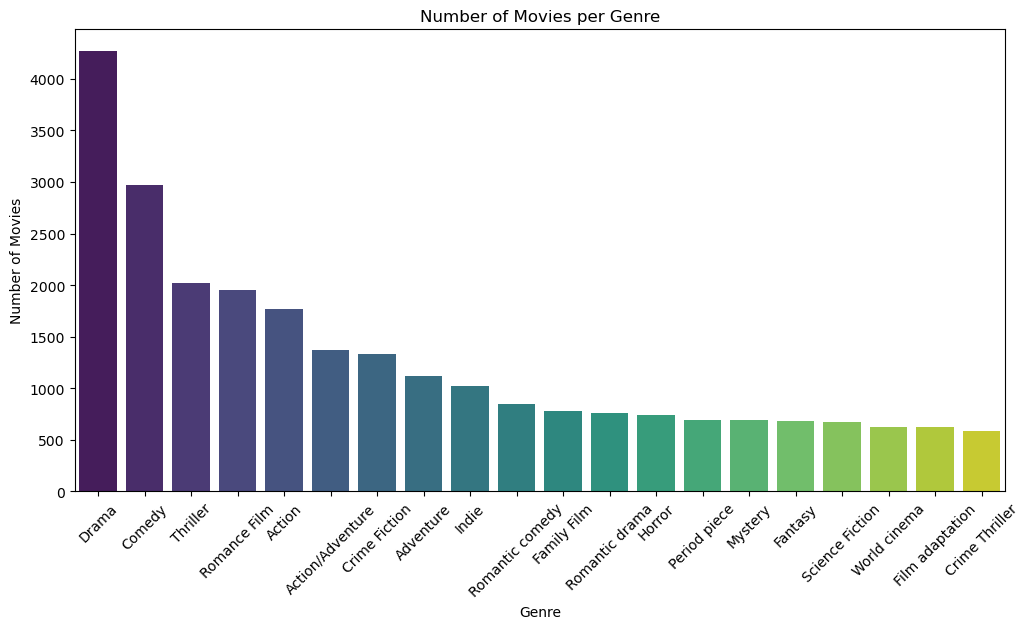

In [8]:
# Explode the genres_list to count each genre separately
genre_counts = df_rating.explode("genres_list")["genres_list"].value_counts()

# get the most common 20 genres
genre_counts_top20 = genre_counts.head(20)


plt.figure(figsize=(12, 6))
sns.barplot(
    x=genre_counts_top20.index,
    y=genre_counts_top20.values,
    palette="viridis",
    hue=genre_counts_top20.index,
)
plt.title("Number of Movies per Genre")
plt.xlabel("Genre")
plt.ylabel("Number of Movies")
plt.xticks(rotation=45)
plt.show()

#### Distribution of IMDb Ratings

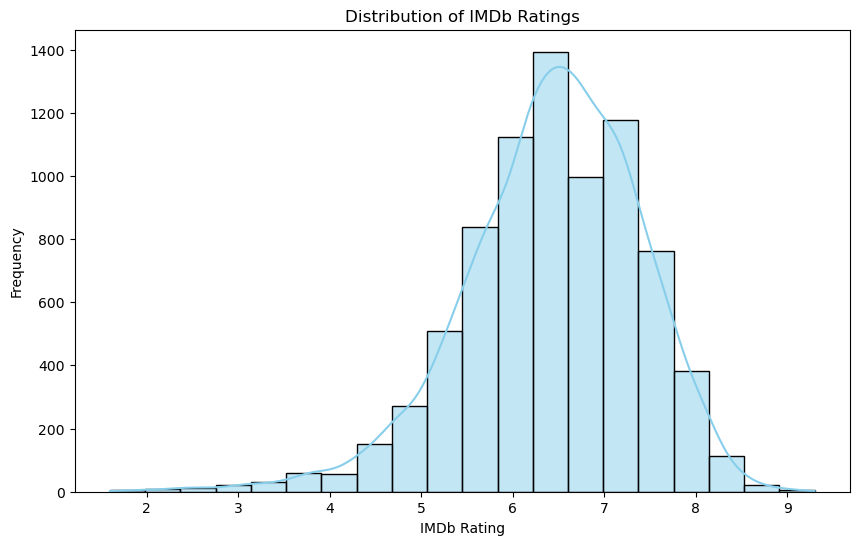

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(df_rating["averageRating"], bins=20, kde=True, color="skyblue")
plt.title("Distribution of IMDb Ratings")
plt.xlabel("IMDb Rating")
plt.ylabel("Frequency")
plt.show()

#### Distribution of Box Office Revenue
Due to the wide range of revenues, we’ll use a logarithmic scale.

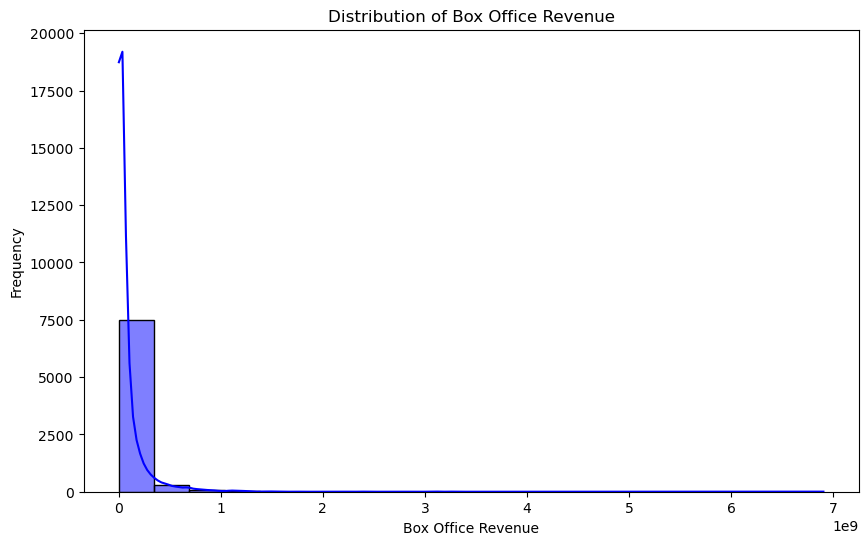

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(df_rating["inflated_revenue"], bins=20, kde=True, color="blue")
plt.title("Distribution of Box Office Revenue")
plt.xlabel("Box Office Revenue")
plt.ylabel("Frequency")
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - For our analysis, we log-transformed the movie revenue data (using log base 10) for several reasons:
    - **Distribution Properties**: As we can see from the Distribution of the Box Office Revenue plot above, movie revenues show a right-skewed distribution with a long tail of high-revenue outliers. Log transformation helps normalize this distribution.
    - **Statistical Considerations**: The transformation helps meet OLS regression assumptions by:
      - Making the relationship more linear
      - Normalizing the distribution of errors

</div>

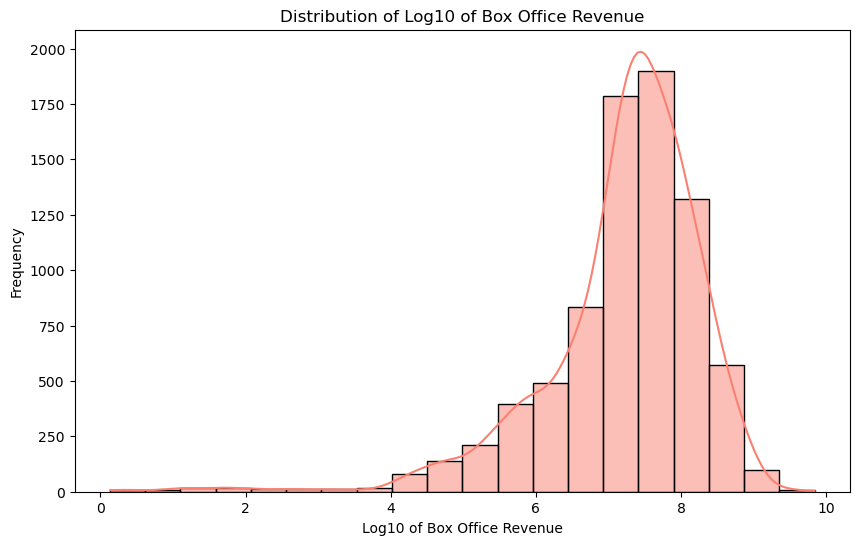

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(np.log10(df_rating["inflated_revenue"]), bins=20, kde=True, color="salmon")
plt.title("Distribution of Log10 of Box Office Revenue")
plt.xlabel("Log10 of Box Office Revenue")
plt.ylabel("Frequency")
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - As shown in the plots above, the log transformation provides a more normally distributed dependent variable.

</div>

#### Scatter Plot of IMDb Ratings vs. Box Office Revenue

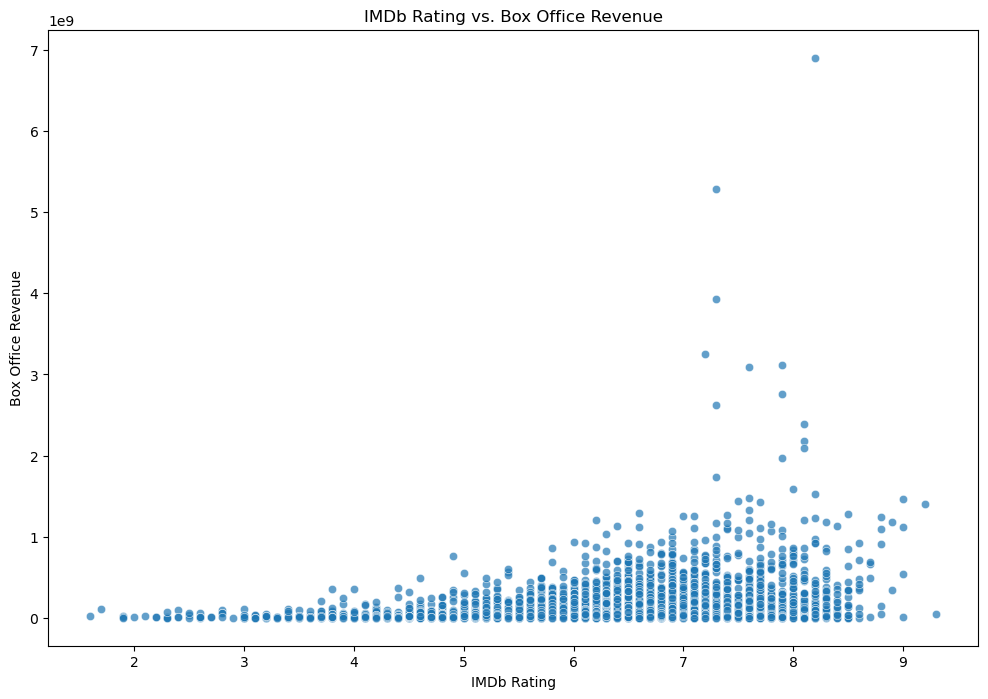

In [12]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x="averageRating", y="inflated_revenue", data=df_rating, alpha=0.7)
plt.title("IMDb Rating vs. Box Office Revenue")
plt.xlabel("IMDb Rating")
plt.ylabel("Box Office Revenue")
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - The scatter plot shows a lot of dispersion. To better visualize the data, we’ll apply a logarithmic transformation to the revenue.

</div>

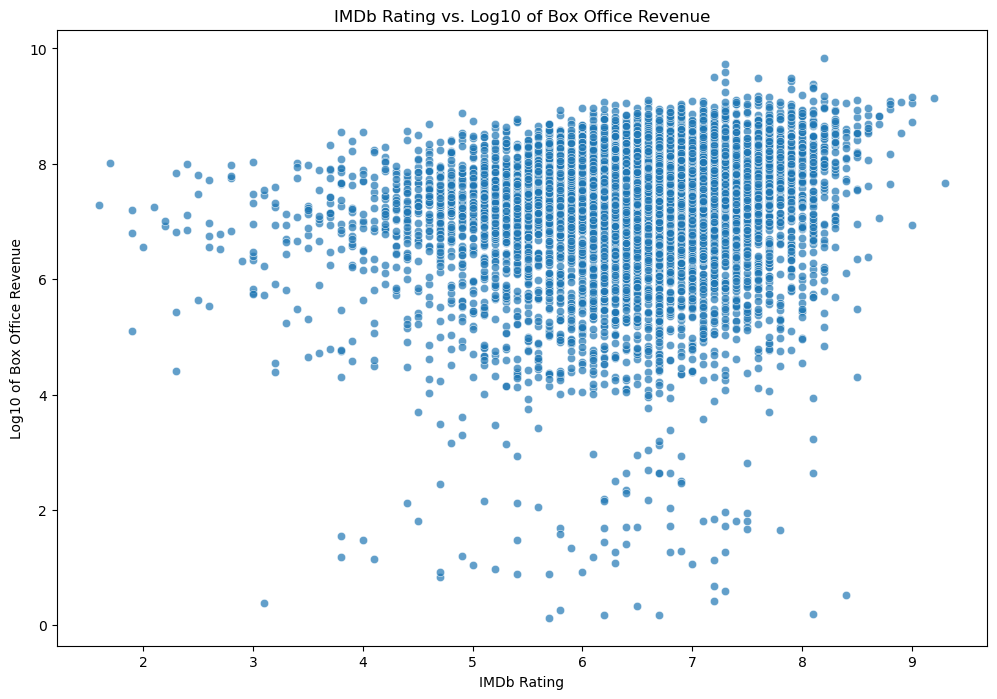

In [13]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="averageRating",
    y=np.log10(df_rating["inflated_revenue"]),
    data=df_rating,
    alpha=0.7,
)
plt.title("IMDb Rating vs. Log10 of Box Office Revenue")
plt.xlabel("IMDb Rating")
plt.ylabel("Log10 of Box Office Revenue")
plt.show()

### Correlation Analysis


Correlation analysis helps in understanding the strength and direction of the relationship between two variables. In this section, we will analyze the correlation between IMDb ratings and box office revenue.

<div class="alert alert-success"> 💭 <strong>Idea:</strong> 

- Determine the strength and direction of the relationship between IMDb ratings and box office revenue. 
- Identify if higher ratings are associated with higher revenues. 
</div> 

<div class="alert alert-warning"> 🛠️ <strong>Methods:</strong> 

- Calculate the Pearson and spearman correlation coefficient between IMDb ratings and box office revenue. 
- Visualize the correlation using a heatmap. 
</div>

#### Calculating the Correlation Coefficient

In [14]:
# Pearson correlation
corr_pearson = df_rating[["averageRating", "inflated_revenue"]].corr(method="pearson")
print("Pearson Correlation Coefficient:")
print(corr_pearson)

# Spearman correlation
corr_spearman = df_rating[["averageRating", "inflated_revenue"]].corr(method="spearman")
print("\nSpearman Correlation Coefficient:")
print(corr_spearman)

Pearson Correlation Coefficient:
                  averageRating  inflated_revenue
averageRating          1.000000          0.189064
inflated_revenue       0.189064          1.000000

Spearman Correlation Coefficient:
                  averageRating  inflated_revenue
averageRating          1.000000          0.157169
inflated_revenue       0.157169          1.000000


#### Heatmap of Correlation Matrix

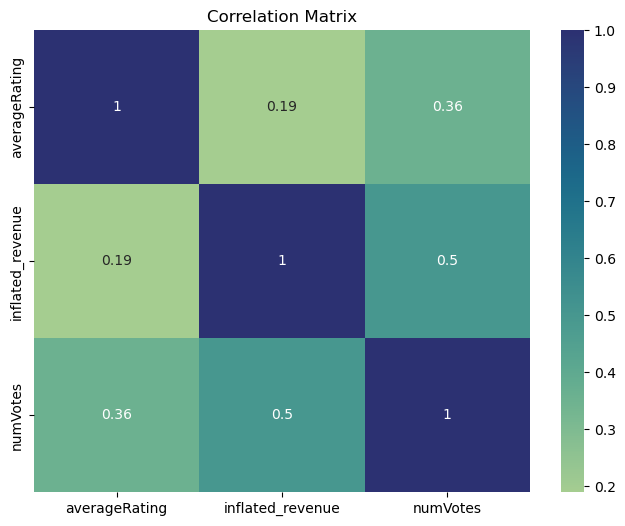

In [15]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    df_rating[["averageRating", "inflated_revenue", "numVotes"]].corr(),
    annot=True,
    cmap="crest",
)
plt.title("Correlation Matrix")
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - The Pearson correlation coefficient between IMDb rating and inflated revenue is 0.188, indicating a weak positive linear relationship.
  - The Spearman correlation coefficient is 0.157, suggests a weak monotonic relationship.

</div>

### Genre-wise Correlation

<div class="alert alert-success"> 💭 <strong>Idea:</strong> 

Different genres might exhibit different relationships between ratings and revenue. As for different genres audiences might have different biases in rating movies. For instance, horror movies might get lower ratings due to the affects they have on the audience, but they might still be successful in terms of revenue.
</div> 

#### Function to Calculate Correlations by Genre

In [16]:
def genre_correlation(genre):
    genre_data = df_rating[df_rating["genres_list"].apply(lambda x: genre in x)]
    pearson_corr, _ = pearsonr(
        genre_data["averageRating"], np.log10(genre_data["inflated_revenue"])
    )
    spearman_corr, _ = spearmanr(
        genre_data["averageRating"], np.log10(genre_data["inflated_revenue"])
    )
    return pd.Series(
        {"Genre": genre, "Pearson": pearson_corr, "Spearman": spearman_corr}
    )

#### Calculate Correlations by Genre

In [17]:
# get top 20 genres
genre_counts_filtered = genre_counts.head(20)
genres = genre_counts_filtered.index.tolist()
genre_corrs = pd.DataFrame([genre_correlation(genre) for genre in genres])
genre_corrs.set_index("Genre", inplace=True)
genre_corrs

Pearson  Spearman
Genre                               
Drama             0.217371  0.230485
Comedy            0.168477  0.186382
Thriller          0.238404  0.258994
Romance Film      0.184061  0.180027
Action            0.279959  0.327892
Action/Adventure  0.254966  0.306993
Crime Fiction     0.204603  0.227275
Adventure         0.255265  0.312972
Indie             0.211690  0.245956
Romantic comedy   0.211127  0.213484
Family Film       0.239712  0.307826
Romantic drama    0.177494  0.173142
Horror            0.235006  0.232137
Period piece      0.342387  0.413234
Mystery           0.250867  0.286732
Fantasy           0.228471  0.265596
Science Fiction   0.273600  0.292991
World cinema      0.033498  0.052916
Film adaptation   0.322260  0.410003
Crime Thriller    0.337234  0.320270

#### Visualizing Genre-wise Correlations

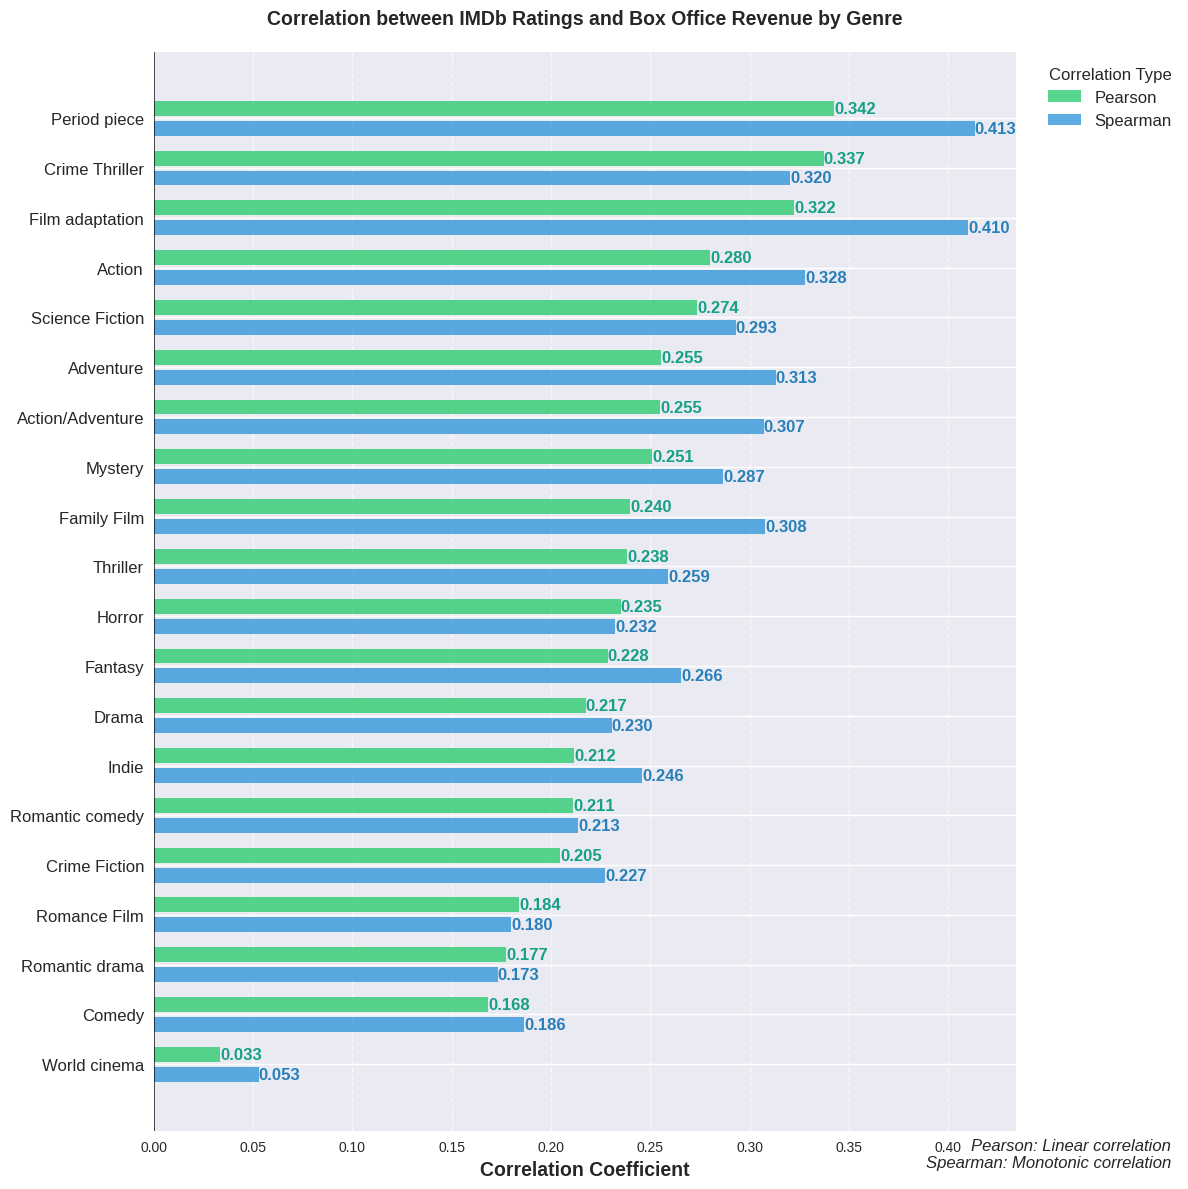

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

# Create figure
fig, ax = plt.subplots(figsize=(12, 12))

# Sort values for better visualization
genre_corrs_sorted = genre_corrs.sort_values("Pearson", ascending=True)

# Create horizontal bar plot with different colors for Pearson and Spearman
x_pearson = genre_corrs_sorted["Pearson"]
x_spearman = genre_corrs_sorted["Spearman"]
y = range(len(genre_corrs_sorted.index))

# update the x-y matching after reordering


# Plot horizontal bars
ax.barh(
    y=[i + 0.2 for i in y],
    width=x_pearson,
    height=0.3,
    color="#2ecc71",
    alpha=0.8,
    label="Pearson",
)
ax.barh(
    y=[i - 0.2 for i in y],
    width=x_spearman,
    height=0.3,
    color="#3498db",
    alpha=0.8,
    label="Spearman",
)

# Customize the plot
ax.set_yticks(y)
ax.set_yticklabels(genre_corrs_sorted.index, fontsize=12)
ax.set_xlabel("Correlation Coefficient", fontsize=14, fontweight="bold")
ax.set_title(
    "Correlation between IMDb Ratings and Box Office Revenue by Genre",
    fontsize=14,
    fontweight="bold",
    pad=20,
)

# Add gridlines
ax.grid(True, axis="x", linestyle="--", alpha=0.7)

# Add zero line
ax.axvline(x=0, color="black", linestyle="-", linewidth=0.5)

# Add legend
ax.legend(
    title="Correlation Type",
    title_fontsize=12,
    fontsize=12,
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
)

# Add value labels on the bars
for i in y:
    # Pearson values
    ax.text(
        x_pearson[i],
        i + 0.2,
        f"{x_pearson[i]:.3f}",
        va="center",
        ha="left" if x_pearson[i] >= 0 else "right",
        fontsize=12,
        fontweight="bold",
        color="#16a085",  # modern teal color
    )
    # Spearman values
    ax.text(
        x_spearman[i],
        i - 0.2,
        f"{x_spearman[i]:.3f}",
        va="center",
        ha="left" if x_spearman[i] >= 0 else "right",
        fontsize=12,
        fontweight="bold",
        color="#2980b9",  # modern blue color
    )

# Add descriptive text
description = "Pearson: Linear correlation\n" "Spearman: Monotonic correlation"
plt.figtext(
    0.98, 0.02, description, fontsize=12, style="italic", ha="right", va="bottom"
)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - Among the genres, some exhibit a stronger correlation between IMDb rating and box office revenue than others.
  - For example, Action movies have a positive correlation of 0.33, while World cinema movies have a near negligible correlation of 0.05.
  - Although the correlation values vary across genres, there is no genre with a negative correlation or a very strong positive correlation between IMDb rating and box office revenue.

</div>

### Regression Analysis

<div class="alert alert-success"> 💭 <strong>Idea:</strong>

 - We build a regression model to predict box office revenue based on IMDb ratings. 
 - The predictive power of IMDb ratings can be assessed on box office revenue. 
 </div> 
 <div class="alert alert-warning"> 🛠️ <strong>Methods:</strong> 
 
 - Use linear regression to model the relationship between IMDb ratings and box office revenue.
  - Evaluate the model's performance using metrics such as R-squared and P values. 
  - Visualize the regression line and residuals. 
  </div>

#### Linear Regression Model

##### Simple Linear Regression

In [19]:
# Prepare the df_rating
X = df_rating[["averageRating"]]
y = np.log10(df_rating["inflated_revenue"])  # Log-transform the revenue

# Add a constant term for the intercept
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       inflated_revenue   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     172.2
Date:                Fri, 06 Dec 2024   Prob (F-statistic):           6.29e-39
Time:                        16:00:10   Log-Likelihood:                -11974.
No. Observations:                7935   AIC:                         2.395e+04
Df Residuals:                    7933   BIC:                         2.397e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             6.1373      0.082     74.471

##### Multiple Linear Regression: IMDb Rating and Number of Votes vs. Box Office Revenue

In [20]:
# Prepare the df_rating
X_multi = df_rating[["averageRating", "numVotes"]]
y_multi = np.log10(df_rating["inflated_revenue"])

# Log-transform numVotes to normalize
X_multi["log_numVotes"] = np.log10(X_multi["numVotes"])

# Add a constant term
X_multi = sm.add_constant(X_multi[["averageRating", "log_numVotes"]])

# Fit the model
model_multi = sm.OLS(y_multi, X_multi).fit()

# Model summary
print(model_multi.summary())

                            OLS Regression Results                            
Dep. Variable:       inflated_revenue   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     1563.
Date:                Fri, 06 Dec 2024   Prob (F-statistic):               0.00
Time:                        16:00:10   Log-Likelihood:                -10741.
No. Observations:                7935   AIC:                         2.149e+04
Df Residuals:                    7932   BIC:                         2.151e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.1264      0.080     51.676

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - **Model Improvement:** Including log-transformed vote count significantly enhanced the model, with R² rising from 0.021 (rating-only) to 0.283, which shows vote count as a stronger revenue predictor than ratings alone.
  - **Surprising Rating Effect Shift:** Controlling for votes, the rating coefficient turns slightly negative (-0.0550) compared to its positive effect (0.1663) in the single predictor model. This indicates that higher ratings don’t necessarily increase revenue once popularity (votes) is considered. (Said's Note: This is a surprising result that may effect our other analysis in this section as well)
  - **Vote Count Impact**: The positive coefficient for log_numVotes (0.7979, p < 0.001) suggests a 10% vote count increase correlates with an 8% revenue boost, that highlights vote count as the primary revenue driver over rating quality.

</div>

#### 3D Visualization of Multiple Linear Regression Model

In [21]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

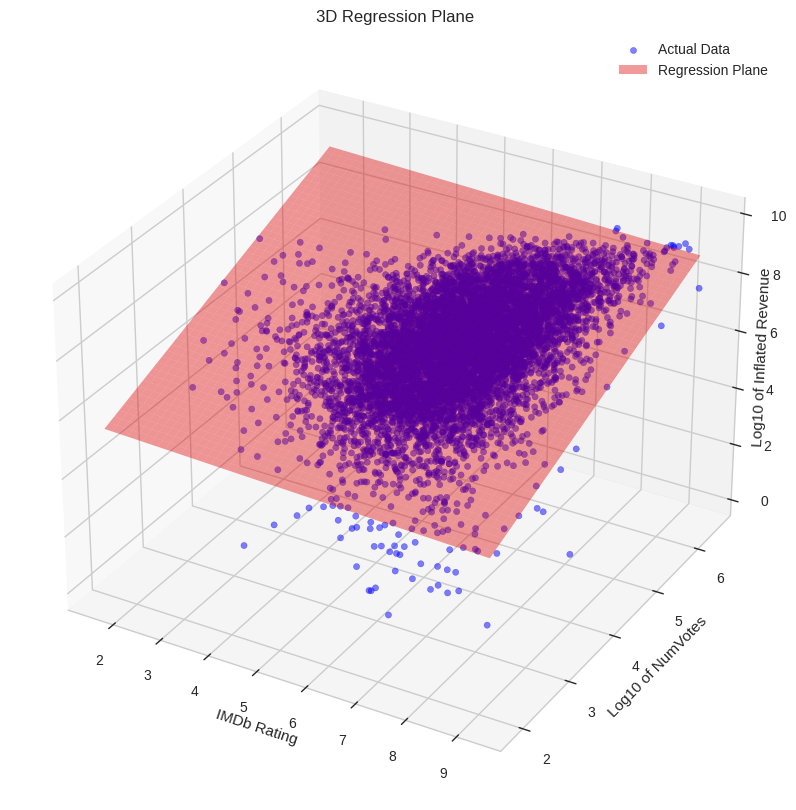

In [22]:
plt.style.use("seaborn-v0_8-whitegrid")

# Create a meshgrid for plotting
averageRating_range = np.linspace(
    df_rating["averageRating"].min(), df_rating["averageRating"].max(), 50
)
log_numVotes_range = np.linspace(
    np.log10(df_rating["numVotes"]).min(), np.log10(df_rating["numVotes"]).max(), 50
)
averageRating_grid, log_numVotes_grid = np.meshgrid(
    averageRating_range, log_numVotes_range
)
predicted_revenue = model_multi.predict(
    sm.add_constant(
        pd.DataFrame(
            {
                "averageRating": averageRating_grid.ravel(),
                "log_numVotes": log_numVotes_grid.ravel(),
            }
        )
    )
).values.reshape(averageRating_grid.shape)

# Plotting
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    df_rating["averageRating"],
    np.log10(df_rating["numVotes"]),
    np.log10(df_rating["inflated_revenue"]),
    c="blue",
    alpha=0.5,
    label="Actual Data",
)
ax.plot_surface(
    averageRating_grid,
    log_numVotes_grid,
    predicted_revenue,
    color="red",
    alpha=0.4,
    label="Regression Plane",
)
ax.set_xlabel("IMDb Rating")
ax.set_ylabel("Log10 of NumVotes")
ax.set_zlabel("Log10 of Inflated Revenue")
# fit z label inside the plot
ax.zaxis.labelpad = -10

plt.title("3D Regression Plane")
plt.legend()
plt.show()

#### Regression Plot

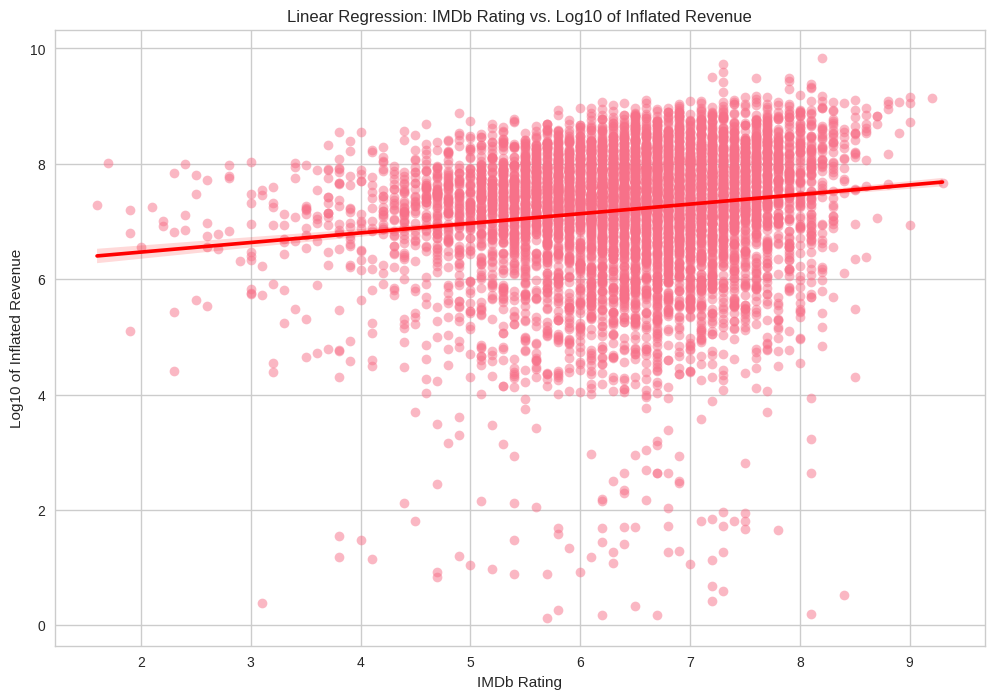

In [23]:
# TODO Said's Note: Since scatter plot is not a good choice to visualize the regression line for this task (as there are thousands of points), we may omit this plot (as the next plot is more informative with hexbins)
plt.figure(figsize=(12, 8))
sns.regplot(
    x="averageRating",
    y=np.log10(df_rating["inflated_revenue"]),
    data=df_rating,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"},
)
plt.title("Linear Regression: IMDb Rating vs. Log10 of Inflated Revenue")
plt.xlabel("IMDb Rating")
plt.ylabel("Log10 of Inflated Revenue")
plt.show()

It is hard to interpret the regression scatter plot due to the high density of points. We can use a hexbin plot to visualize the relationship better.

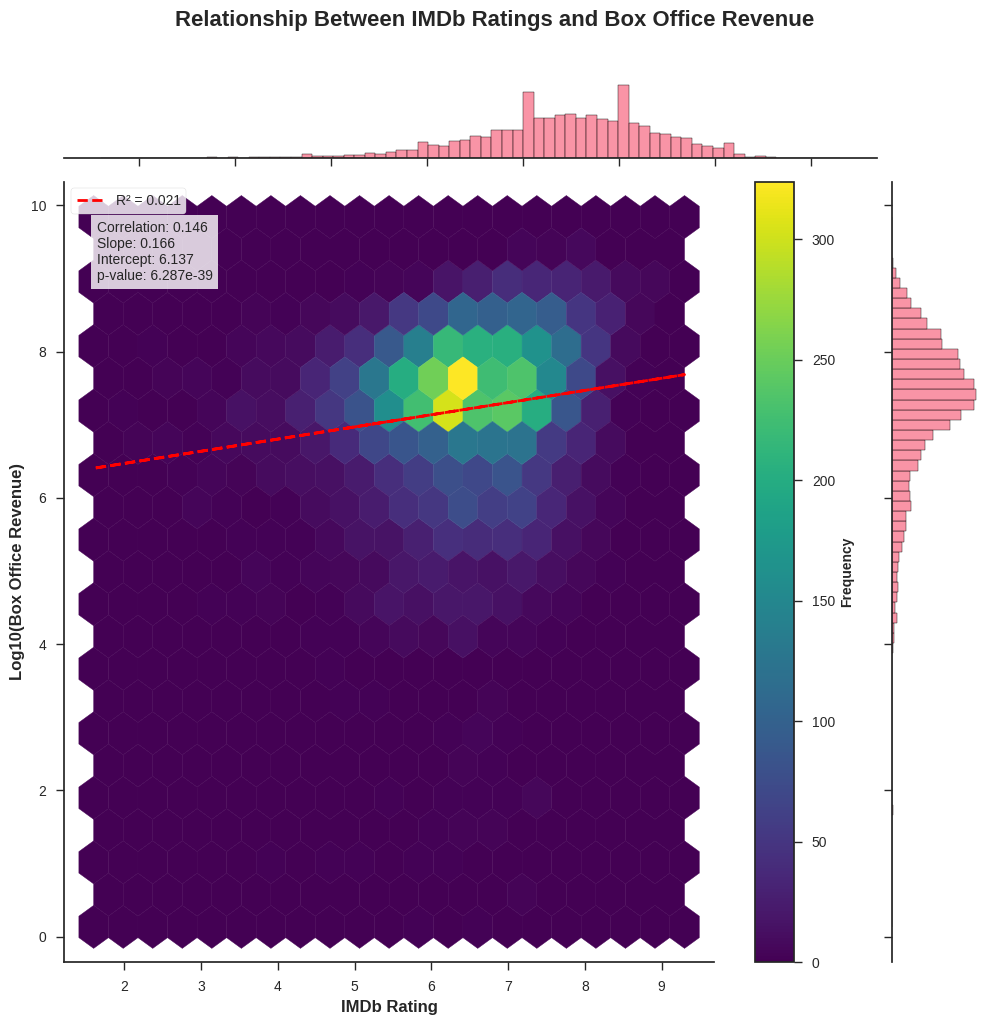

In [24]:
# Create figure with custom size and style
plt.style.use("seaborn-v0_8-ticks")
sns.set_palette("husl")

# Creation of the joint plot
g = sns.jointplot(
    data=df_rating,
    x="averageRating",
    y=np.log10(df_rating["inflated_revenue"]),
    kind="hex",
    height=10,  # figure size
    ratio=8,  # the ratio of main plot to marginal plots
    marginal_kws=dict(bins=70),  # More bins in marginal plots
    joint_kws=dict(gridsize=20),  # More hexbins for better resolution
    palette="viridis",  # Modern color palette
)

# Add trend line
x = df_rating["averageRating"]
y = np.log10(df_rating["inflated_revenue"])
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
line = slope * x + intercept
g.ax_joint.plot(
    x, line, color="red", linestyle="--", linewidth=2, label=f"R² = {r_value**2:.3f}"
)

# Customize the plot
g.figure.suptitle(
    "Relationship Between IMDb Ratings and Box Office Revenue",
    y=1.02,
    fontsize=16,
    fontweight="bold",
)

# Add descriptive labels
g.ax_joint.set_xlabel("IMDb Rating", fontsize=12, fontweight="bold")
g.ax_joint.set_ylabel("Log10(Box Office Revenue)", fontsize=12, fontweight="bold")

# Add legend with modern color
g.ax_joint.legend(loc="upper left", fontsize=10, frameon=True, facecolor="white")


# Add text box with statistics
stats_text = (
    f"Correlation: {r_value:.3f}\n"
    f"Slope: {slope:.3f}\n"
    f"Intercept: {intercept:.3f}\n"
    f"p-value: {p_value:.3e}"
)
g.ax_joint.text(
    0.05,
    0.95,
    stats_text,
    transform=g.ax_joint.transAxes,
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"),
    fontsize=10,
    verticalalignment="top",
)

# Customize hexbin appearance
g.ax_joint.collections[0].set_cmap("viridis")  # Modern colormap


# Add color bar
cbar = g.figure.colorbar(g.ax_joint.collections[0], ax=g.ax_joint, label="Count")
cbar.set_label("Frequency", fontsize=10, fontweight="bold")

# Tight layout
plt.tight_layout()

# Show the plot
plt.show()

<div class="alert alert-info"> 📢 <strong>Discussion:</strong> 

- The regression analysis provides a quantitative measure of the relationship between IMDb ratings and box office revenue.
- The visualization, including the regression line and hexbin plot, helps in understanding the distribution of data points and the fit of the regression model. 
- The color bar provides additional context by showing the frequency of data points in different regions of the plot.
- The slope of the regression line shows the rate at which box office revenue changes with respect to IMDb ratings. And since the slope is not significant, we can say that the relationship is weak.
- The p-value indicates the statistical significance of the relationship, with a low p-value suggesting that the observed relationship is unlikely to be due to chance. 
 </div>

# Movie 2: Tongues 🗣 
## How do the language and country of a movie influence its box office revenue?

</div> <div class="alert alert-success"> 🎞️ <strong>Movie Trailer:</strong>

**TODO:** Feel free to modify this part. 

This analysis aims to explore the importance of a movie's primary language and release country, as well as the correlation between these two aspects. Additionally, it wants to show whether movies with more than one original language achieve more success.

**🏗️ Analysis Structure:**

- **Data Preparation**
  - Relevant columns
  - Handling missing values
  - Handling duplicates
  - ...
- **Exploratory Data Analysis**
  - ...
- **Regression Analysys**
- ...


</div>

### Data Preparation

#### Relevant Columns

For this analysis, we will focus on the following columns:

- `movie_name`: Add description 
- `movie_languages`: Add description
- `movie_countries`: Add description
- `inflated_revenue`: Add description

We will create 3 different dataframes:
- `df_movie_country`: Dataframe specific to the country.
- `df_movie_language`: Dataframe specific to the languages.
- `df_movie_country_language`: Dataframe for both country and languages.

 
Note: The dataframe df_movie_country_language would be enough for the whole part. However, for sake of clarity, we will use different dataframes for each subpart.

In [25]:
# create the specific dataframes
df_movie_country = df[["movie_name", "movie_countries", "inflated_revenue"]]
df_movie_language = df[["movie_name", "movie_languages", "inflated_revenue"]]
df_movie_country_language = df[
    ["movie_name", "movie_languages", "movie_countries", "inflated_revenue"]
]

#### Handling Missing Values

In each dataframe, rows that don't contain any value for on of the mentioned columns are removed.

In [26]:
# drop rows with NaN values
df_movie_country.dropna(inplace=True)
df_movie_language.dropna(inplace=True)
df_movie_country_language.dropna(inplace=True)

# print the number of rows where the movie_countries list is empty
print(
    "Number of rows where movie_countries list is empty: ",
    df_movie_country[df_movie_country["movie_countries"] == "[]"].shape[0],
)
# print the number of rows where the movie_languages list is empty
print(
    "Number of rows where movie_languages list is empty: ",
    df_movie_language[df_movie_language["movie_languages"] == "[]"].shape[0],
)
# print the number of rows where either movie_countries or movie_languages list is empty
print(
    "Number of rows where movie_countries or movie_languages list is empty: ",
    df_movie_country_language[
        (df_movie_country_language["movie_countries"] == "[]")
        | (df_movie_country_language["movie_languages"] == "[]")
    ].shape[0],
)

# remove such rows in all dataframes
df_movie_country = df_movie_country[
    df_movie_country["movie_countries"].apply(lambda x: len(ast.literal_eval(x)) > 0)
]
df_movie_language = df_movie_language[
    df_movie_language["movie_languages"].apply(lambda x: len(ast.literal_eval(x)) > 0)
]
df_movie_country_language = df_movie_country_language[
    df_movie_country_language["movie_countries"].apply(
        lambda x: len(ast.literal_eval(x)) > 0
    )
    & df_movie_country_language["movie_languages"].apply(
        lambda x: len(ast.literal_eval(x)) > 0
    )
]

# safety check
print("-----Pre-processed data-----")
print(
    "Number of rows where movie_countries list is empty: ",
    df_movie_country[df_movie_country["movie_countries"] == "[]"].shape[0],
)
print(
    "Number of rows where movie_languages list is empty: ",
    df_movie_language[df_movie_language["movie_languages"] == "[]"].shape[0],
)
print(
    "Number of rows where movie_countries or movie_languages list is empty: ",
    df_movie_country_language[
        (df_movie_country_language["movie_countries"] == "[]")
        | (df_movie_country_language["movie_languages"] == "[]")
    ].shape[0],
)

Number of rows where movie_countries list is empty:  131
Number of rows where movie_languages list is empty:  344
Number of rows where movie_countries or movie_languages list is empty:  372
-----Pre-processed data-----
Number of rows where movie_countries list is empty:  0
Number of rows where movie_languages list is empty:  0
Number of rows where movie_countries or movie_languages list is empty:  0


#### Handling Duplicates

In [27]:
# check for duplicates
print("Duplicates in df_movie_country: ", df_movie_country.duplicated().sum())
print("Duplicates in df_movie_language: ", df_movie_language.duplicated().sum())
print(
    "Duplicates in df_movie_country_language: ",
    df_movie_country_language.duplicated().sum(),
)

# remove duplicates
df_movie_country.drop_duplicates(inplace=True)
df_movie_language.drop_duplicates(inplace=True)
df_movie_country_language.drop_duplicates(inplace=True)

# safety check
print("-----Pre-processed data-----")
print("Duplicates in df_movie_country: ", df_movie_country.duplicated().sum())
print("Duplicates in df_movie_language: ", df_movie_language.duplicated().sum())
print(
    "Duplicates in df_movie_country_language: ",
    df_movie_country_language.duplicated().sum(),
)

Duplicates in df_movie_country:  15
Duplicates in df_movie_language:  15
Duplicates in df_movie_country_language:  10
-----Pre-processed data-----
Duplicates in df_movie_country:  0
Duplicates in df_movie_language:  0
Duplicates in df_movie_country_language:  0


#### Dataframe check :)

In [28]:
df_movie_country.head()

movie_name                              movie_countries  \
0            Ghosts of Mars  [('/m/09c7w0', 'United States of America')]   
1  Alexander's Ragtime Band  [('/m/09c7w0', 'United States of America')]   
2                   Henry V             [('/m/07ssc', 'United Kingdom')]   
3              Mary Poppins  [('/m/09c7w0', 'United States of America')]   
4            New Rose Hotel  [('/m/09c7w0', 'United States of America')]   

   inflated_revenue  
0      1.899115e+07  
1      6.812740e+07  
2      1.967252e+07  
3      7.913870e+08  
4      3.100822e+04

In [29]:
df_movie_language.head()

movie_name                       movie_languages  \
0            Ghosts of Mars  [('/m/02h40lc', 'English Language')]   
1  Alexander's Ragtime Band  [('/m/02h40lc', 'English Language')]   
2                   Henry V  [('/m/02h40lc', 'English Language')]   
3              Mary Poppins  [('/m/02h40lc', 'English Language')]   
4            New Rose Hotel  [('/m/02h40lc', 'English Language')]   

   inflated_revenue  
0      1.899115e+07  
1      6.812740e+07  
2      1.967252e+07  
3      7.913870e+08  
4      3.100822e+04

In [30]:
df_movie_country_language.head()

movie_name                       movie_languages  \
0            Ghosts of Mars  [('/m/02h40lc', 'English Language')]   
1  Alexander's Ragtime Band  [('/m/02h40lc', 'English Language')]   
2                   Henry V  [('/m/02h40lc', 'English Language')]   
3              Mary Poppins  [('/m/02h40lc', 'English Language')]   
4            New Rose Hotel  [('/m/02h40lc', 'English Language')]   

                               movie_countries  inflated_revenue  
0  [('/m/09c7w0', 'United States of America')]      1.899115e+07  
1  [('/m/09c7w0', 'United States of America')]      6.812740e+07  
2             [('/m/07ssc', 'United Kingdom')]      1.967252e+07  
3  [('/m/09c7w0', 'United States of America')]      7.913870e+08  
4  [('/m/09c7w0', 'United States of America')]      3.100822e+04

### Exploratory Data Analysis

<div class="alert alert-success">

  💭 <strong>Idea:</strong>

  - Analyse the number of countries and languages in the dataset
  - Check which ones are most common
  - Think about how this distribution could influence/ change further analysis
  
</div>

<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>
  - Extract the unique country and language names and print the absolute frequency for the most common ones
    - Only the first country and language are taken since they are considered the main ones. Taking all the others of the list would probably give them too much importance compared to the main ones.
  - Print the total number of different countries and languages
  - Visualization: Plot the most common countries and languages in a bar chart
</div>

In [31]:
def extract_names(columns):
    """
    Extracts the names from columns of the data (for countries and languages for example)
    Args:
        columns: list of columns
    Returns:
        names: list of names
    """
    names = []
    for column in columns:
        literals = ast.literal_eval(column)
        names.extend([literals[1] for literals in literals])
    return names

In [32]:
# extract all possible countries and languages
countries = extract_names(df_movie_country_language["movie_countries"])
languages = extract_names(df_movie_country_language["movie_languages"])

# count
countries_count = pd.Series(countries).value_counts()
languages_count = pd.Series(languages).value_counts()

# print the top 10 countries and languages
print(f"Top 10 countries:\n{countries_count.head(10)}")
print(f"Top 10 languages:\n{languages_count.head(10)}")

Top 10 countries:
United States of America    7545
United Kingdom              1098
France                       628
Germany                      514
Canada                       383
South Korea                  246
Japan                        232
Australia                    211
Italy                        190
India                        134
Name: count, dtype: int64
Top 10 languages:
English Language     8326
French Language       644
Spanish Language      484
German Language       308
Italian Language      279
Korean Language       257
Japanese Language     254
Russian Language      217
Standard Mandarin     145
Hindi Language        101
Name: count, dtype: int64


In [33]:
# print the number of different countries and languages
print(f"Number of different countries: {len(countries_count)}")
print(f"Number of different languages: {len(languages_count)}")

Number of different countries: 105
Number of different languages: 158


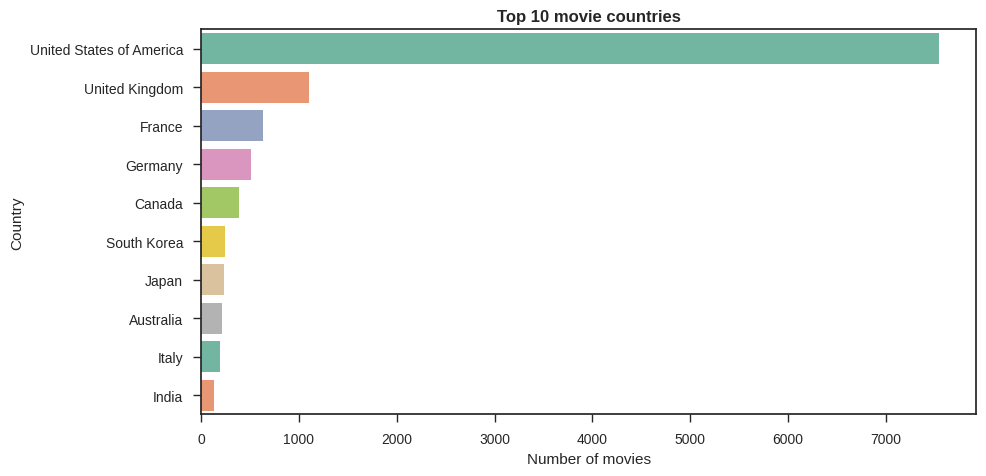

In [34]:
# plot the top n countries
top_n = 10

plt.figure(figsize=(10, 5))
sns.barplot(
    x=countries_count.head(top_n).values,
    y=countries_count.head(top_n).index,
    palette="Set2",
)
plt.title("Top 10 movie countries", fontweight="bold")
plt.xlabel("Number of movies")
plt.ylabel("Country")
plt.show()

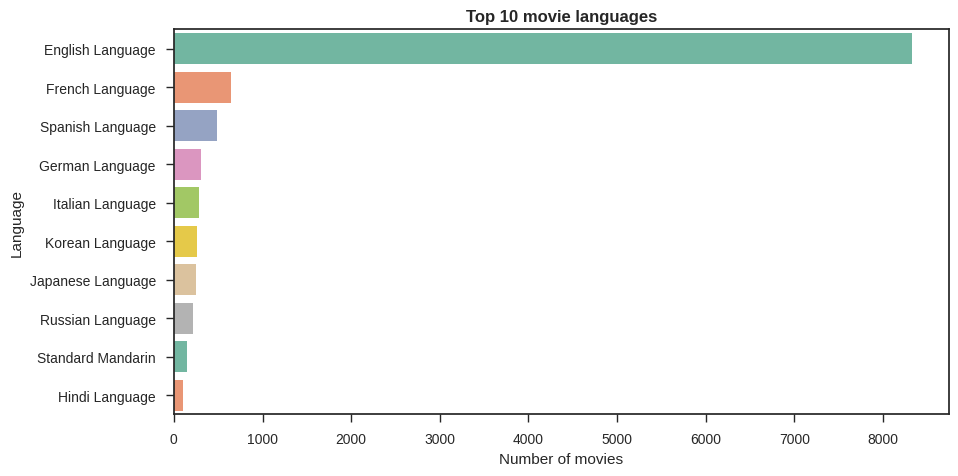

In [35]:
# plot the top n languages
plt.figure(figsize=(10, 5))
sns.barplot(
    x=languages_count.head(top_n).values,
    y=languages_count.head(top_n).index,
    palette="Set2",
)
plt.title("Top 10 movie languages", fontweight="bold")
plt.xlabel("Number of movies")
plt.ylabel("Language")
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - As expected, the English speaking countries are leading. 
  - The same applies for the language. As expected, English is leading. 
  - The difference between the leading categories and the other ones is considerably high.
    
</div>

### Language influence

<div class="alert alert-success">

  💭 <strong>Idea:</strong>

  - Analyse the influence of the language on the box office revenue
  - Only consider the first mentioned language in the list of languages (see also explanation in the methods box higher above for more explanation)
  
</div>

<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>
  - Extract the first language in the language list for each movie
  - Visualization: Plot the languages and their average box office revenue in a bar chart
  - Regression analysis
  - Statistical hypothesis testing: ANOVA
  - Apply a threshold to consider only languages having a representative amount of movies, repeat several analysis with this modified data
  
</div>

In [36]:
def extract_first_language(language_list):
    """
    Extract only the first language of the list of all languages
    Args:
        language_list: a list of all languages for a movie
    Returns:
        first_language: the first language for the given movie
    """
    parsed_language_list = ast.literal_eval(language_list)
    first_language = parsed_language_list[0][1]

    return first_language

In [37]:
# extract the first language for each movie
df_movie_language["first_language"] = df_movie_language["movie_languages"].apply(
    extract_first_language
)

# check
df_movie_language[["movie_name", "movie_languages", "first_language"]].head(10)

movie_name  \
0               Ghosts of Mars   
1     Alexander's Ragtime Band   
2                      Henry V   
3                 Mary Poppins   
4               New Rose Hotel   
5                     Baby Boy   
6   They Knew What They Wanted   
7       The Gods Must Be Crazy   
8                 Rudo y Cursi   
9  Kinjite: Forbidden Subjects   

                                     movie_languages      first_language  
0               [('/m/02h40lc', 'English Language')]    English Language  
1               [('/m/02h40lc', 'English Language')]    English Language  
2               [('/m/02h40lc', 'English Language')]    English Language  
3               [('/m/02h40lc', 'English Language')]    English Language  
4               [('/m/02h40lc', 'English Language')]    English Language  
5               [('/m/02h40lc', 'English Language')]    English Language  
6               [('/m/02h40lc', 'English Language')]    English Language  
7  [('/m/0x82', 'Afrikaans Language'), ('/m/02h40...  Afrikaans Language  
8                 [('/m/06nm1', 'Spanish Language')]    Spanish Language  
9               [('/m/02h40lc', 'English Language')]    English Language

In [38]:
# average box office revenue per language (only considering the fist languages for each movie)
average_revenue_per_language = (
    df_movie_language.groupby("first_language")["inflated_revenue"]
    .mean()
    .sort_values(ascending=False)
)

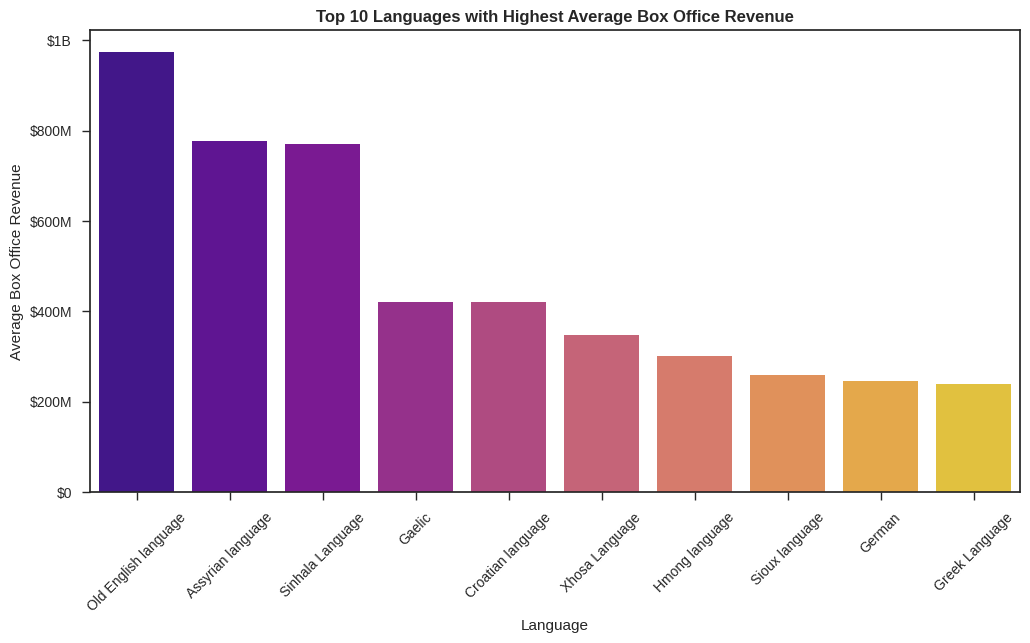

In [39]:
# plot the top n languages with highest average box office revenue
top_n = 10

plt.figure(figsize=(12, 6))
sns.barplot(
    x=average_revenue_per_language.head(top_n).index,
    y=average_revenue_per_language.head(top_n).values,
    palette="plasma",
)
plt.title(
    f"Top {top_n} Languages with Highest Average Box Office Revenue", fontweight="bold"
)
plt.xlabel("Language")
plt.ylabel("Average Box Office Revenue")

plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(revenue_formatter)
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - It can be seen that very unknown languages appear to have a high average box revenue. A possible explanation could be: Since the languages are unknown, they don't have a lot of movies. Therefore, their mean is less representative (it could be the mean of only 10 movies). 
  - In order to remove such cases, where the mean is not be representative, a threshold is set. Only languages with more movies than this threshold are kept and the same analysis is done again. 
    
</div>

In [40]:
# count the number of movies per language
movies_per_language = df_movie_language["first_language"].value_counts()
# only get the languages with more than a certain number of movies
threshold = 50
common_languages = movies_per_language[movies_per_language > threshold].index

# average box office revenue per language with applying the threshold
average_revenue_per_language_threshold = (
    df_movie_language[df_movie_language["first_language"].isin(common_languages)]
    .groupby("first_language")["inflated_revenue"]
    .mean()
).sort_values(ascending=False)

In [41]:
# print the common languages
print(f"Common languages with more than {threshold} movies:\n{common_languages}")

Common languages with more than 50 movies:
Index(['English Language', 'French Language', 'Korean Language',
       'Japanese Language', 'Italian Language', 'Hindi Language',
       'German Language', 'Russian Language', 'Standard Mandarin',
       'Arabic Language'],
      dtype='object', name='first_language')


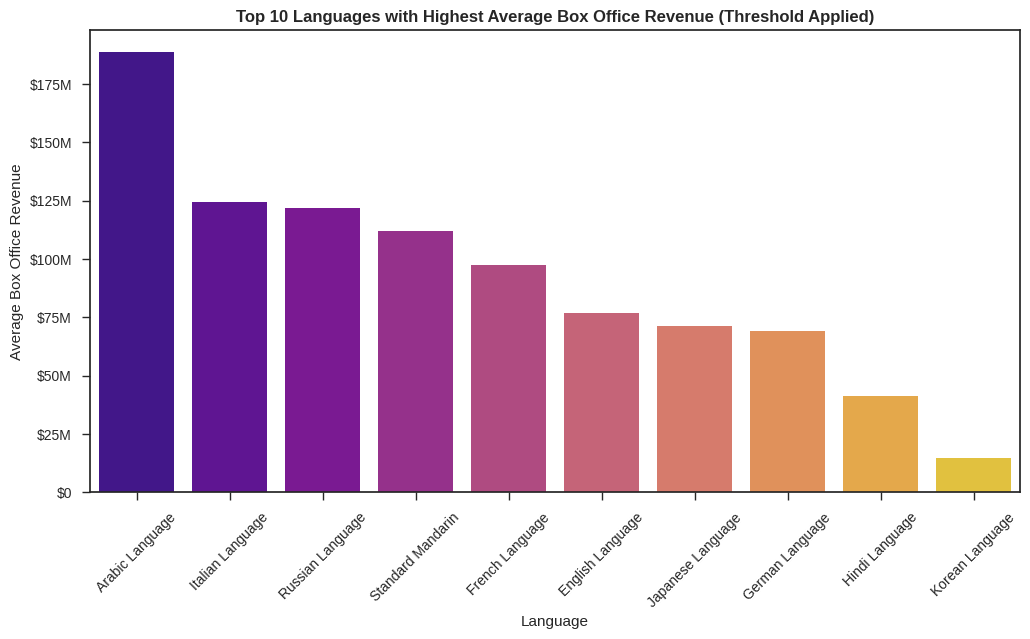

In [42]:
# plot the top n languages with highest average box office revenue (after applying the threshold)
top_n = 10

plt.figure(figsize=(12, 6))
sns.barplot(
    x=average_revenue_per_language_threshold.head(top_n).index,
    y=average_revenue_per_language_threshold.head(top_n).values,
    palette="plasma",
)
plt.title(
    f"Top {top_n} Languages with Highest Average Box Office Revenue (Threshold Applied)",
    fontweight="bold",
)
plt.xlabel("Language")
plt.ylabel("Average Box Office Revenue")
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(revenue_formatter)
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - The plot looks quite different, containing more common languages.
  - **TODO:** Explore this in more detail. How many movies does each language have? How can we get a representing mean? ... 
    
</div>

#### Regression analysis

The language (categorical) should predict the box office revenue (continuous). An ordinary least squares (OLS) regression can be done. The categorical variable has to be one-hot encoded. Each language will get an own coefficient, indicating its influence on the box office revenue compared to the baseline language.

In [43]:
# one-hot encode the language column
# baseline language -> the most common language
X = pd.get_dummies(df_movie_language["first_language"], drop_first=True).astype(int)

y = np.log10(df_movie_language["inflated_revenue"].astype(float))

# Add intercept
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       inflated_revenue   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     3.028
Date:                Fri, 06 Dec 2024   Prob (F-statistic):           4.01e-23
Time:                        16:00:13   Log-Likelihood:                -13691.
No. Observations:                9220   AIC:                         2.760e+04
Df Residuals:                    9112   BIC:                         2.837e+04
Df Model:                         107                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - The R-squared value is very low, indicating that the model does not explain a lot of variability in the data so the fit is not really good.
  - Some very low p-values appear for very uncommon languages (for example Crow Language or Chechen Language). This would mean that their influence on the box office revenue is significant. However, as already mentioned earlier, this might be due to the fact that for these languages there are not enough movies. 
  - Again, a threshold is applied and the analysis repeated.
    
</div>

In [44]:
# one-hot encode the language column
# baseline language -> the most common language
# only take the common languages
X = pd.get_dummies(
    df_movie_language[df_movie_language["first_language"].isin(common_languages)][
        "first_language"
    ],
    drop_first=True,
).astype(int)

y = np.log10(
    df_movie_language[df_movie_language["first_language"].isin(common_languages)][
        "inflated_revenue"
    ].astype(float)
)

# Add intercept
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       inflated_revenue   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     8.741
Date:                Fri, 06 Dec 2024   Prob (F-statistic):           3.45e-13
Time:                        16:00:13   Log-Likelihood:                -12805.
No. Observations:                8589   AIC:                         2.563e+04
Df Residuals:                    8579   BIC:                         2.570e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 7.5338      0.14

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - The R-squared value remains very low. 
  - Some p-values are low, indicating that the influence of the corresponding languages is significant. 
  - All the coefficients are negative. This would mean that every of the mentioned languages has a negative influence on the box office revenue.
  - **TODO:** Explore this in more detail. What could be possible reasons for such a results?
    
</div>

#### ANOVA

An ANOVA analysis can be done in order to determine if there are statistically significant differences in box office revenue across different languages.

In [45]:
# define and fit the model
anova_model = ols("inflated_revenue ~ C(first_language)", data=df_movie_language).fit()
# get the anova table
anova_table = sm.stats.anova_lm(anova_model, typ=2)

print(anova_table)

                         sum_sq      df         F        PR(>F)
C(first_language)  9.263444e+18   107.0  2.203867  1.716580e-11
Residual           3.579455e+20  9112.0       NaN           NaN


<div class="alert alert-info">
  💡 <strong>Discussion:</strong>
  
  - The p-value is very low, indicating that there is a statistically significant influence of the language on the box office revenue.
  - This ANOVA was performed without applying the threshold. Let's applied the threshold and check again!
  
</div>

In [46]:
# ANOVA only with the common languages
# define and fit the model
anova_model_threshold = ols(
    "inflated_revenue ~ C(first_language)",
    data=df_movie_language[df_movie_language["first_language"].isin(common_languages)],
).fit()
# get the anova table
anova_table_threshold = sm.stats.anova_lm(anova_model_threshold, typ=2)

print(anova_table_threshold)

                         sum_sq      df         F        PR(>F)
C(first_language)  2.539489e+18     9.0  7.095707  2.638227e-10
Residual           3.411496e+20  8579.0       NaN           NaN


<div class="alert alert-info">
  💡 <strong>Discussion:</strong>
  
  - The p-value is again very low, confirming that there is a statistically significant influence of the language on the box office revenue (even when removing some unrepresentative cases).
  - This is as expected! 
  - **TODO:** Further investigate the influence of language on box office revenue
  
</div>

### Country influence

<div class="alert alert-success">

  💭 <strong>Idea:</strong>

  - Analyse the influence of the country on the box office revenue
  - Only consider the first mentioned country in the list of countries
  
</div>

<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>
  - Extract the first country in the country list for each movie
  - Visualization: Plot the countries and their average box office revenue in a bar chart
  - Regression analysis
  - Statistical hypothesis testing: ANOVA
  - Apply a threshold to consider only countries having a representative amount of movies, repeat several analysis with this modified data
  
</div>

In [47]:
# check if some rows have multiple countries (in the list of countries)
num_rows_with_multiple_countries = (
    df_movie_country["movie_countries"]
    .apply(lambda x: len(ast.literal_eval(x)) > 1)
    .sum()
)
print("Number of rows with more than one country:", num_rows_with_multiple_countries)

Number of rows with more than one country: 2198


In [48]:
def extract_first_country(country_list):
    """
    Extract only the first country of the list of all countries
    Args:
        country_list: a list of all countries for a movie
    Returns:
        first_country: the first country for the given movie
    """
    parsed_country_list = ast.literal_eval(country_list)
    first_country = parsed_country_list[0][1]

    return first_country

In [49]:
# only take the first country
df_movie_country["first_country"] = df_movie_country["movie_countries"].apply(
    extract_first_country
)

# check
df_movie_country[["movie_name", "movie_countries", "first_country"]].head(10)

movie_name  \
0               Ghosts of Mars   
1     Alexander's Ragtime Band   
2                      Henry V   
3                 Mary Poppins   
4               New Rose Hotel   
5                     Baby Boy   
6   They Knew What They Wanted   
7       The Gods Must Be Crazy   
8                 Rudo y Cursi   
9  Kinjite: Forbidden Subjects   

                                     movie_countries             first_country  
0        [('/m/09c7w0', 'United States of America')]  United States of America  
1        [('/m/09c7w0', 'United States of America')]  United States of America  
2                   [('/m/07ssc', 'United Kingdom')]            United Kingdom  
3        [('/m/09c7w0', 'United States of America')]  United States of America  
4        [('/m/09c7w0', 'United States of America')]  United States of America  
5        [('/m/09c7w0', 'United States of America')]  United States of America  
6        [('/m/09c7w0', 'United States of America')]  United States of America  
7                     [('/m/0hzlz', 'South Africa')]              South Africa  
8  [('/m/0b90_r', 'Mexico'), ('/m/09c7w0', 'Unite...                    Mexico  
9        [('/m/09c7w0', 'United States of America')]  United States of America

In [50]:
# average box office revenue per country (only considering the fist countries for each movie)
average_revenue_per_country = (
    df_movie_country.groupby("first_country")["inflated_revenue"]
    .mean()
    .sort_values(ascending=False)
)

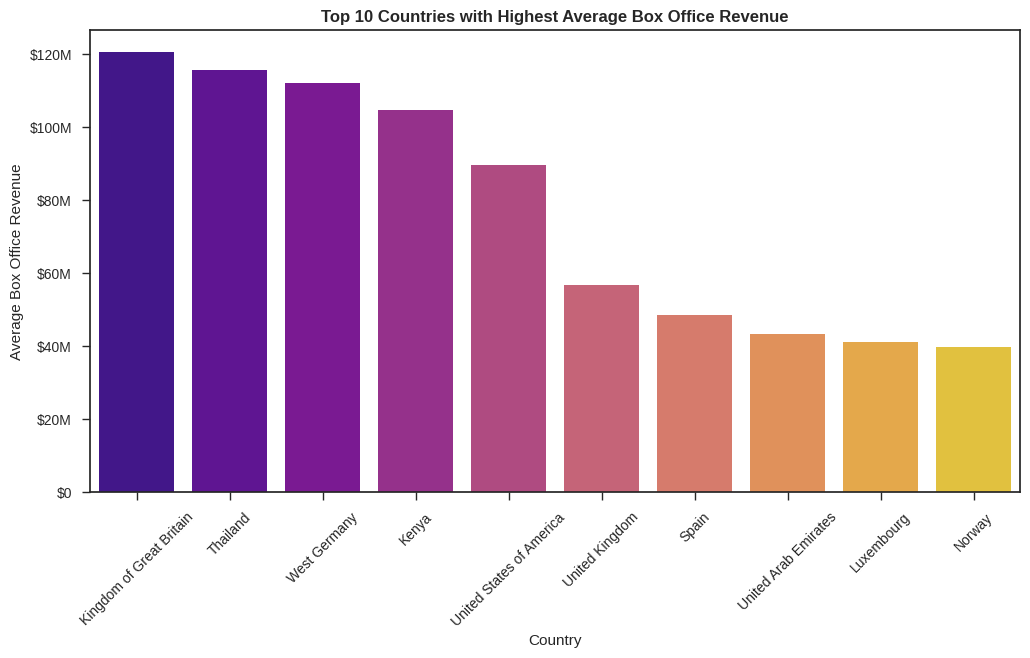

In [51]:
# plot the top n countries with highest average box office revenue
top_n = 10

plt.figure(figsize=(12, 6))
sns.barplot(
    x=average_revenue_per_country.head(top_n).index,
    y=average_revenue_per_country.head(top_n).values,
    palette="plasma",
)
plt.title(
    f"Top {top_n} Countries with Highest Average Box Office Revenue", fontweight="bold"
)
plt.xlabel("Country")
plt.ylabel("Average Box Office Revenue")
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(revenue_formatter)
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>
  
  - Some of the countries are very common and their results seem to be as expected.
  - However, there are again some uncommon cases (as for the languages). These might be removed by applying a threshold. 
  
</div>

In [52]:
# count the number of movies per country
movies_per_country = df_movie_country["first_country"].value_counts()
# only get the countries with more than a certain number of movies
threshold = 40
common_countries = movies_per_country[movies_per_country > threshold].index

# average box office revenue per country with applying the threshold
average_revenue_per_country_threshold = (
    df_movie_country[df_movie_country["first_country"].isin(common_countries)]
    .groupby("first_country")["inflated_revenue"]
    .mean()
).sort_values(ascending=False)

In [53]:
# print the common countries
print(f"Common countries with more than {threshold} movies:\n{common_countries}")

Common countries with more than 40 movies:
Index(['United States of America', 'France', 'South Korea', 'United Kingdom',
       'Japan', 'India', 'Australia', 'Canada', 'Hong Kong', 'Spain'],
      dtype='object', name='first_country')


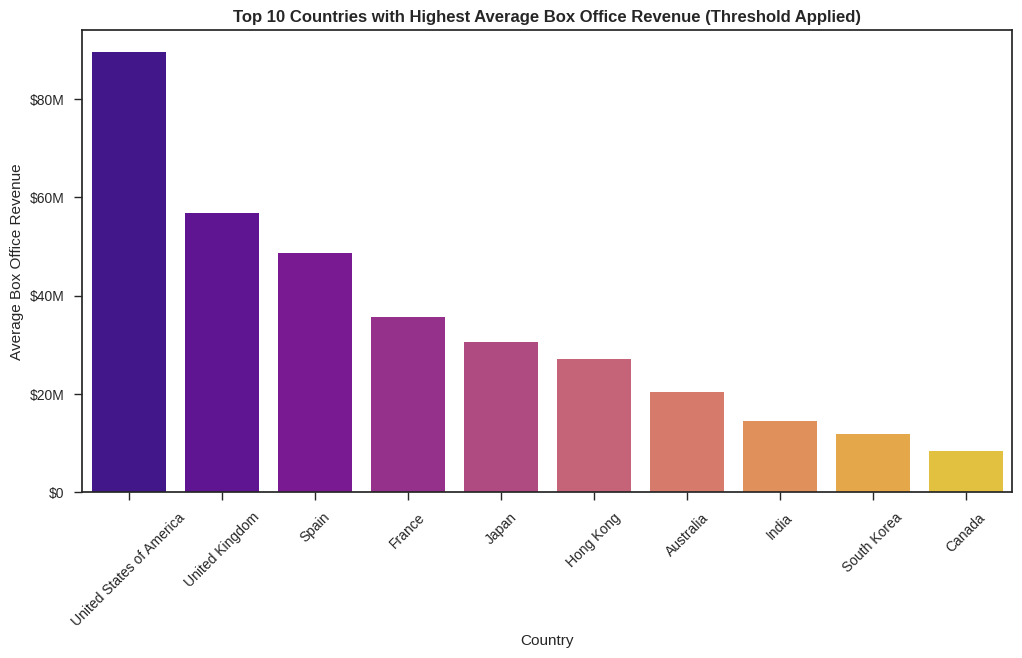

In [54]:
# plot the top n countries with highest average box office revenue
top_n = 10

plt.figure(figsize=(12, 6))
sns.barplot(
    x=average_revenue_per_country_threshold.head(top_n).index,
    y=average_revenue_per_country_threshold.head(top_n).values,
    palette="plasma",
)
plt.title(
    f"Top {top_n} Countries with Highest Average Box Office Revenue (Threshold Applied)",
    fontweight="bold",
)
plt.xlabel("Country")
plt.ylabel("Average Box Office Revenue")
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(revenue_formatter)
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>
  
  - The plot no longer contains the very uncommon countries that might not have a representative number of movies. 
  - **TODO:** Explore this in more detail
  
</div>

#### Regression analysis

The country (categorical) should predict the box office revenue (continuous). An ordinary least squares (OLS) regression can be done. The categorical variable has to be one-hot encoded. Each country will get an own coefficient, indicating its influence on the box office revenue compared to the baseline country.

In [55]:
# one-hot encode the country column
# baseline country -> the most common country
X = pd.get_dummies(df_movie_country["first_country"], drop_first=True).astype(int)

y = np.log10(df_movie_country["inflated_revenue"].astype(float))

# Add intercept
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       inflated_revenue   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     10.22
Date:                Fri, 06 Dec 2024   Prob (F-statistic):           7.89e-95
Time:                        16:00:14   Log-Likelihood:                -13944.
No. Observations:                9433   AIC:                         2.802e+04
Df Residuals:                    9368   BIC:                         2.848e+04
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - The R-squared value is very low, indicating that the model does not explain a lot of variability in the data so the fit is not really good.
  - Some low p-values can be found for some rich countries as Switzerland or United Arab Emirates. In these cases the coefficient is positive, meaning that these countries have a positive influence on the box office revenue. This actually makes sense and is as expected. 
  - **TODO:** Go into more detail with the analysis, perform it also for the data with a threshold applied and compare 
    
</div>

#### ANOVA

An ANOVA analysis can be done in order to determine if there are statistically significant differences in box office revenue across different countries.

In [56]:
# define and fit the model
anova_model = ols("inflated_revenue ~ C(first_country)", data=df_movie_country).fit()
# get the anova table
anova_table = sm.stats.anova_lm(anova_model, typ=2)

print(anova_table)

                        sum_sq      df         F        PR(>F)
C(first_country)  6.095020e+18    64.0  2.461818  9.507744e-10
Residual          3.623982e+20  9368.0       NaN           NaN


<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - The p-value is low, indicating that the country actually has an influence on the box office revenue. 
  - **TODO:** To the same also for the data with the threshold applied and compare, explore in more detail

  
</div>

### Relation between language and country

<div class="alert alert-success">

  💭 <strong>Idea:</strong>

  - Analyse the correlation between the country and the language
  - Use the information to guide further anaylsis and to interpret previous one

</div>

<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>
  - Statistical hypothesis testing: ANOVA
  - Correlation analysis
  - Regression analyis
  
</div>

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>


</div>

### Multilingual movies

<div class="alert alert-success">

  💭 <strong>Idea:</strong>

  - Analyse the influence of multilinguality in the movies
  - Do multilingual movies have more success (in terms of box office revenue)?
  - Is there a relation between the number of languages spoken in a movie and its box office revenue?
  - Keep in mind that if a movie has more than one language listed, it means the languages used in the original version (not the translations later on)

</div>

<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>
  - Statistical hypothesis testing: ANOVA
  
</div>

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>


</div>

# Movie 3: Shades 🎭 
## How does a movie's genre impact its box office revenue?

</div> <div class="alert alert-success"> 🎞️ <strong>Movie Trailer:</strong>

This film aims to provide an understanding of whether certain genres are associated with higher revenues and if the relationship between genre and revenue changes over time.

**🏗️ Analysis Structure:**

- **Data Preparation**
  - Relevant columns
  - Handling missing values
  - Handling duplicates
  - ...
- **Exploratory Data Analysis**
  - ...
- **Regression Analysis**
  - ...
- ...


</div>

### Data Preparation

#### Relevant Columns

For this analysis, we'll focus on the following columns:
- `movie_name`: Add description
- `movie_genres`: Add description
- `inflated_revenue`: Add description
- `release_year`: Add description

In [57]:
# select relevant columns
df_genres = df[["movie_name", "movie_genres", "inflated_revenue", "release_year"]]

#### Handling Missing Values

#### Handling Duplicates

### Exploratory Data Analysis

Before addressing our research question, it's important to familiarize ourselves with the dataset. To do this, we aim to answer the following questions:

- How many different genres are there in our dataset? 
- How many movies are there per genre?
- How many movies are categorized under more than one genre?

In [58]:
# convert string to list of genres
df_genres["movie_genres"] = df_genres["movie_genres"].apply(
    lambda x: [t[1] for t in eval(x)]
)

In [59]:
# get all unique genres across all movies
all_genres = set()
for genres in df_genres["movie_genres"]:
    all_genres.update(genres)

print(f"Number of unique genres: {len(all_genres)}")
print("Unique genres:")
print(sorted(all_genres))

Number of unique genres: 317
Unique genres:
['Absurdism', 'Acid western', 'Action', 'Action Comedy', 'Action Thrillers', 'Action/Adventure', 'Addiction Drama', 'Adult', 'Adventure', 'Adventure Comedy', 'Airplanes and airports', 'Albino bias', 'Alien Film', 'Alien invasion', 'Americana', 'Animal Picture', 'Animals', 'Animated Musical', 'Animated cartoon', 'Animation', 'Anime', 'Anthology', 'Anthropology', 'Anti-war', 'Anti-war film', 'Apocalyptic and post-apocalyptic fiction', 'Archaeology', 'Archives and records', 'Art film', 'Auto racing', 'Avant-garde', 'B-Western', 'B-movie', 'Backstage Musical', 'Baseball', 'Beach Film', 'Bengali Cinema', 'Biker Film', 'Biographical film', 'Biography', 'Biopic [feature]', 'Black comedy', 'Black-and-white', 'Blaxploitation', 'Bloopers & Candid Camera', 'Bollywood', 'Boxing', 'Breakdance', 'British Empire Film', 'British New Wave', 'Buddy cop', 'Buddy film', 'Business', 'Camp', 'Caper story', 'Cavalry Film', 'Chase Movie', 'Childhood Drama', "Childre

In [60]:
# count number of movies per genre
genre_count = {}
for genres in df_genres["movie_genres"]:
    for genre in genres:
        if genre not in genre_count:
            genre_count[genre] = 0
        genre_count[genre] += 1

# convert to dataframe and sort by count
genre_df = pd.DataFrame.from_dict(genre_count, orient="index", columns=["count"])
genre_df = genre_df.sort_values("count", ascending=False)

print("Number of movies per genre:")
print(tabulate(genre_df, headers="keys", tablefmt="psql"))

Number of movies per genre:
+------------------------------------------+---------+
|                                          |   count |
|------------------------------------------+---------|
| Drama                                    |    5014 |
| Comedy                                   |    3516 |
| Romance Film                             |    2302 |
| Thriller                                 |    2265 |
| Action                                   |    2027 |
| Action/Adventure                         |    1553 |
| Crime Fiction                            |    1503 |
| Adventure                                |    1316 |
| Indie                                    |    1229 |
| Romantic comedy                          |     973 |
| Family Film                              |     925 |
| Romantic drama                           |     884 |
| Horror                                   |     875 |
| World cinema                             |     808 |
| Fantasy                            

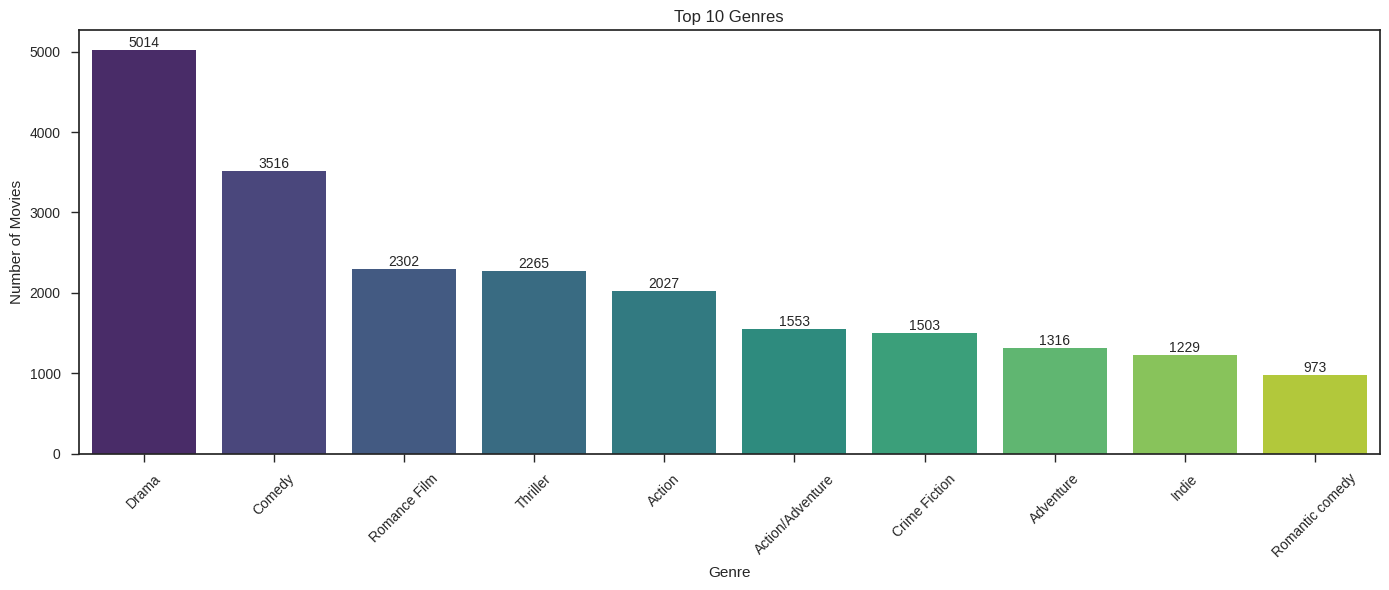

In [61]:
# plot top 10 most common genres as a bar plot
top_10_genres = genre_df.head(10)
plt.figure(figsize=(14, 6))
ax = sns.barplot(
    x=top_10_genres.index,
    y=top_10_genres["count"],
    hue=top_10_genres.index,
    palette="viridis",
)
# add the number of movies above each bar
for i, v in enumerate(top_10_genres["count"]):
    ax.text(i, v, str(int(v)), ha="center", va="bottom")
plt.xticks(rotation=45)
plt.title("Top 10 Genres")
plt.xlabel("Genre")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()

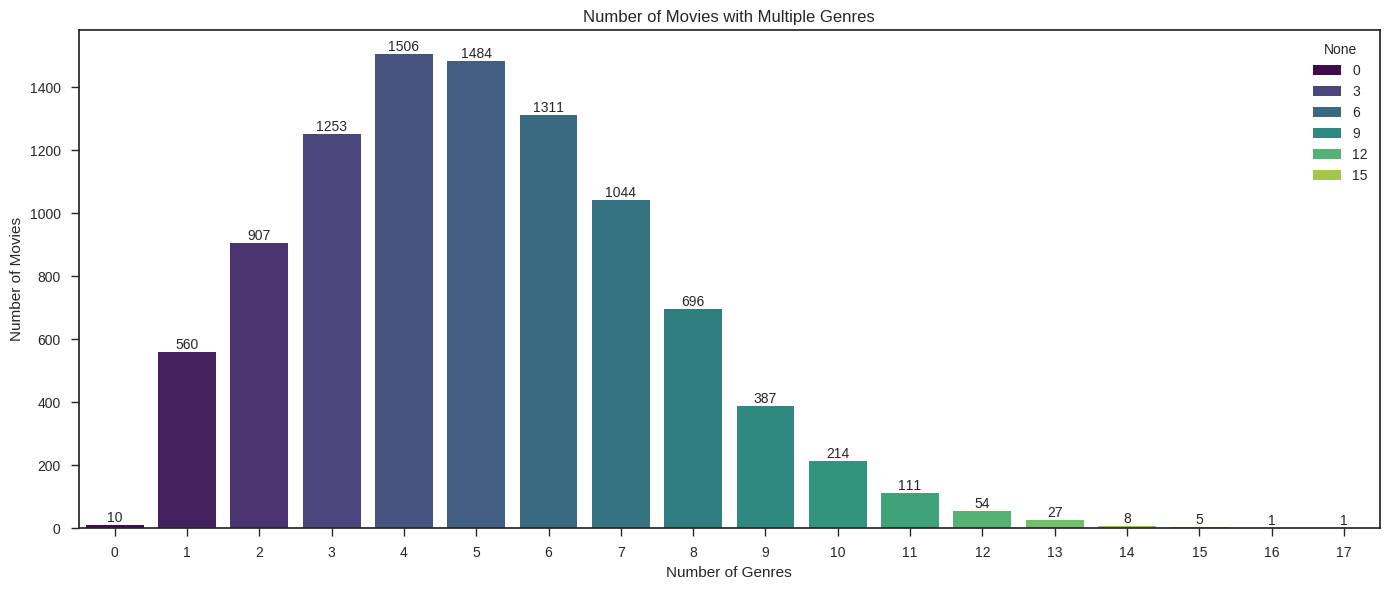

In [62]:
# count the movies with multiple genres
multi_genre_counts = {}
for genres in df_genres["movie_genres"]:
    if len(genres) not in multi_genre_counts:
        multi_genre_counts[len(genres)] = 0
    multi_genre_counts[len(genres)] += 1

# convert to dataframe and sort by count
multi_genre_df = pd.DataFrame.from_dict(
    multi_genre_counts, orient="index", columns=["count"]
)
multi_genre_df = multi_genre_df.sort_index()

# plot number of movies with multiple genres as a bar plot
plt.figure(figsize=(14, 6))
ax = sns.barplot(
    x=multi_genre_df.index,
    y=multi_genre_df["count"],
    hue=multi_genre_df.index,
    palette="viridis",
)
# add the number of movies above each bar
for i, v in enumerate(multi_genre_df["count"]):
    ax.text(i, v, str(int(v)), ha="center", va="bottom")
plt.title("Number of Movies with Multiple Genres")
plt.xlabel("Number of Genres")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()

In [63]:
# print the percentage of movies with more than one genre
percentage = (len(df_genres) - multi_genre_counts[1]) / len(df_genres) * 100
print(
    f"Percentage of movies with more than one genre: {percentage:.2f}%",
)

Percentage of movies with more than one genre: 94.15%


<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - There are 317 different genres in our dataset. 
  - The top 10 most common genres are: Drama, Comedy, Romance Film, Thriller, Action, Action/Adventure, Crime Fiction, Adventure, Indie and Romantic comedy.
  - 94.15 % of the movies have more than one genre.
</div>

Analyzing revenue patterns across all 317 genres in our dataset is impractical, so we will focus our analysis on the 10 most common genres.

In [64]:
# we will focus on the top 10 genres for the rest of the analysis
top_10_genres_list = sorted(genre_df.head(10).index.tolist())
print("Top 10 genres:")
print(top_10_genres_list)

# create a new dataframe with exploded genres, revenues and release years
df_genre_revenue = df_genres.explode("movie_genres")[
    ["movie_genres", "inflated_revenue", "release_year"]
]
# filter for only top-10 genres
df_genre_revenue = df_genre_revenue[
    df_genre_revenue["movie_genres"].isin(top_10_genres_list)
]
# sort by genre name
df_genre_revenue = df_genre_revenue.sort_values("movie_genres")

# add log transformed revenue
df_genre_revenue["log_revenue"] = np.log10(df_genre_revenue["inflated_revenue"])

print("\nNumber of rows in the new exploded dataframe:", len(df_genre_revenue))

Top 10 genres:
['Action', 'Action/Adventure', 'Adventure', 'Comedy', 'Crime Fiction', 'Drama', 'Indie', 'Romance Film', 'Romantic comedy', 'Thriller']

Number of rows in the new exploded dataframe: 21698


<div class="alert alert-success">

  💭 <strong> Other ideas: </strong>
  
  - Should we also analyze the genre combinations, e.g. Drama + Romance?
  - Are movies with more than 1 genre more profitable?
  
</div>

### What are the average and median revenues for each genre?

This question aims to identify which genres tend to perform better financially and detect any clear outliers.

<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>
  - Desctiptive statistics: mean, median, standard error of the mean
  - Visualization: bar plot
</div>

We will first compute the mean, median and standard error of the box office revenues for each of the top-10 genres.


In [65]:
# calculate average, median and standard error of the revenue per genre
genre_revenue_stats = (
    df_genre_revenue.groupby("movie_genres")
    .agg({"inflated_revenue": ["mean", "median", "sem"]})
    .round(2)
)

# rename columns
genre_revenue_stats.columns = ["mean", "median", "sem"]
# sort by mean revenue
genre_revenue_stats = genre_revenue_stats.sort_values("mean", ascending=False)

print("Revenue statistics by genre (in dollars):")
print(tabulate(genre_revenue_stats, headers="keys", tablefmt="psql"))

Revenue statistics by genre (in dollars):
+------------------+-------------+-------------+-------------+
| movie_genres     |        mean |      median |         sem |
|------------------+-------------+-------------+-------------|
| Adventure        | 1.77227e+08 | 4.9472e+07  | 9.41716e+06 |
| Action           | 1.29697e+08 | 4.00426e+07 | 5.10951e+06 |
| Action/Adventure | 1.19006e+08 | 3.95344e+07 | 5.10398e+06 |
| Thriller         | 9.73651e+07 | 3.20046e+07 | 3.78318e+06 |
| Romance Film     | 7.56037e+07 | 2.20915e+07 | 4.74556e+06 |
| Comedy           | 7.40884e+07 | 2.58359e+07 | 2.24098e+06 |
| Crime Fiction    | 7.28373e+07 | 2.07549e+07 | 3.43501e+06 |
| Drama            | 6.83878e+07 | 1.72904e+07 | 2.90103e+06 |
| Romantic comedy  | 6.29251e+07 | 2.66943e+07 | 3.162e+06   |
| Indie            | 2.20571e+07 | 3.54938e+06 | 1.6801e+06  |
+------------------+-------------+-------------+-------------+


For better interpretation, we will also use a bar plot to vizualize the means and standard error for each genre.

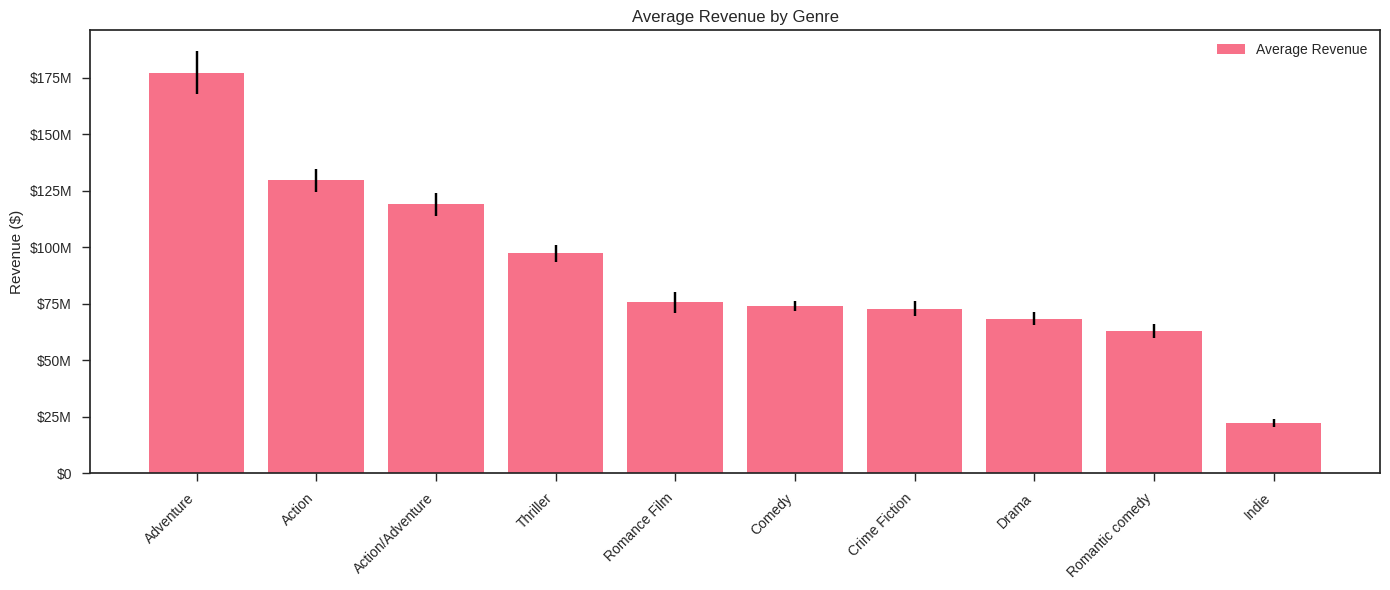

In [66]:
x = np.arange(len(genre_revenue_stats.index))
fig, ax = plt.subplots(figsize=(14, 6))
rects = ax.bar(
    x,
    genre_revenue_stats["mean"],
    label="Average Revenue",
    yerr=genre_revenue_stats["sem"],
)
ax.set_ylabel("Revenue ($)")
ax.set_title("Average Revenue by Genre")
ax.set_xticks(x)
ax.set_xticklabels(genre_revenue_stats.index, rotation=45, ha="right")
ax.legend()
# format y-axis to use dollars
ax.yaxis.set_major_formatter(plt.FuncFormatter(revenue_formatter))
plt.tight_layout()
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - **Drama** is the most popular genre, appearing in 5042 movies. However, ranked by average revenue it is on the 8-th spot.
</div>

### What is the distribution of revenues within each genre? Are there high variability and skewness?

This question aims to explore if specific genres have wider distributions in revenue, indicating higher financial risk or reward. 

<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>
  - Descriptive statistics: interquartile range, variance and skewness
  - Visualization: box plot or violin plot
</div>

In [67]:
# calculate interquartile range, variance and skewness for each genre
genre_revenue_stats = (
    df_genre_revenue.groupby("movie_genres")["log_revenue"]
    .agg(["min", "max", "mean", "median", "std", "var", "skew"])
    .round(2)
)
print("Revenue statistics by genre (in log10(dollars)):")
print(tabulate(genre_revenue_stats, headers="keys", tablefmt="psql"))

Revenue statistics by genre (in log10(dollars)):
+------------------+-------+-------+--------+----------+-------+-------+--------+
| movie_genres     |   min |   max |   mean |   median |   std |   var |   skew |
|------------------+-------+-------+--------+----------+-------+-------+--------|
| Action           |  0.13 |  9.49 |   7.5  |     7.6  |  1.01 |  1.01 |  -2.1  |
| Action/Adventure |  0.13 |  9.44 |   7.52 |     7.6  |  0.94 |  0.88 |  -2.05 |
| Adventure        |  0.18 |  9.72 |   7.64 |     7.69 |  0.94 |  0.89 |  -1.72 |
| Comedy           |  0.18 |  9.11 |   7.22 |     7.41 |  1.06 |  1.13 |  -1.8  |
| Crime Fiction    |  0.34 |  9.15 |   7.15 |     7.32 |  1.1  |  1.2  |  -1.55 |
| Drama            |  0.17 |  9.84 |   7.04 |     7.24 |  1.1  |  1.22 |  -1.4  |
| Indie            |  0.34 |  8.89 |   6.41 |     6.55 |  1.16 |  1.34 |  -1    |
| Romance Film     |  0.17 |  9.84 |   7.16 |     7.34 |  1.08 |  1.17 |  -1.82 |
| Romantic comedy  |  0.84 |  8.93 |   7.22 |    

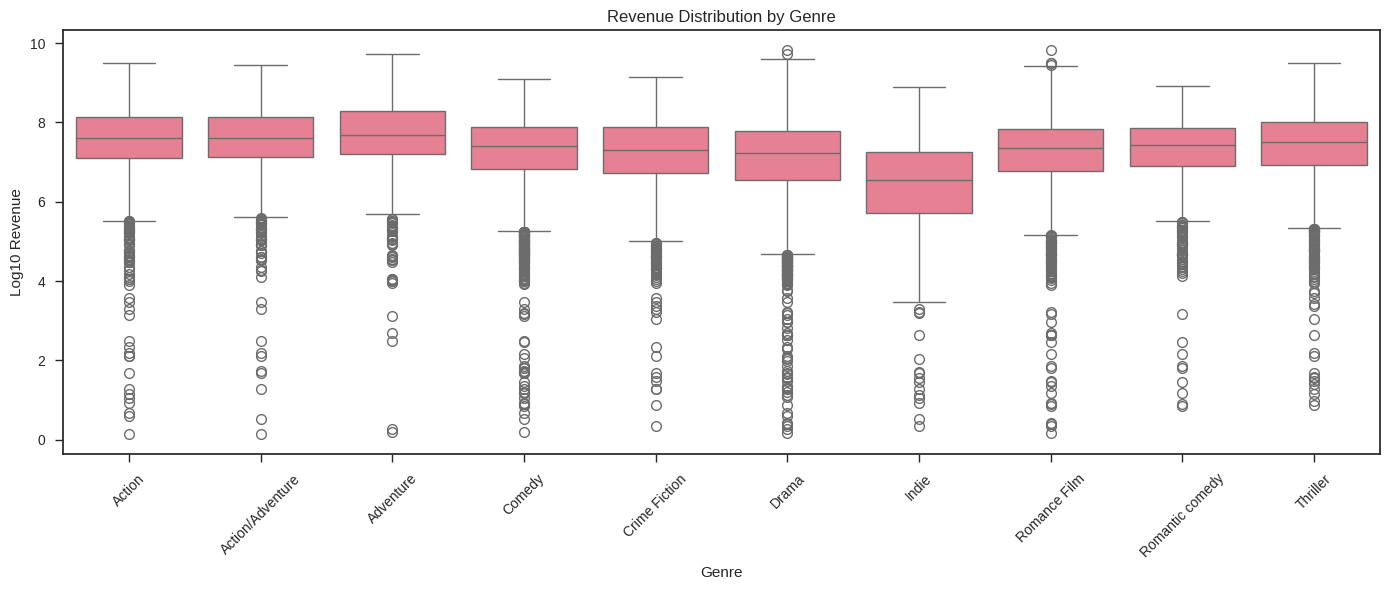

In [68]:
# plot box plots for each genre
plt.figure(figsize=(14, 6))
sns.boxplot(
    x="movie_genres", y="log_revenue", data=df_genre_revenue, showfliers=True
)  # TODO: when True the outliers are shown (doesn't look good)
plt.xticks(rotation=45)
plt.title("Revenue Distribution by Genre")
plt.xlabel("Genre")
plt.ylabel("Log10 Revenue")
plt.tight_layout()
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>
  
</div>


### How has the revenue of each genre changed over time?

This question aims to answer whether certain genres have more (or less) popular or profitable over time.

<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>
  - Visualization: Line plot
</div>

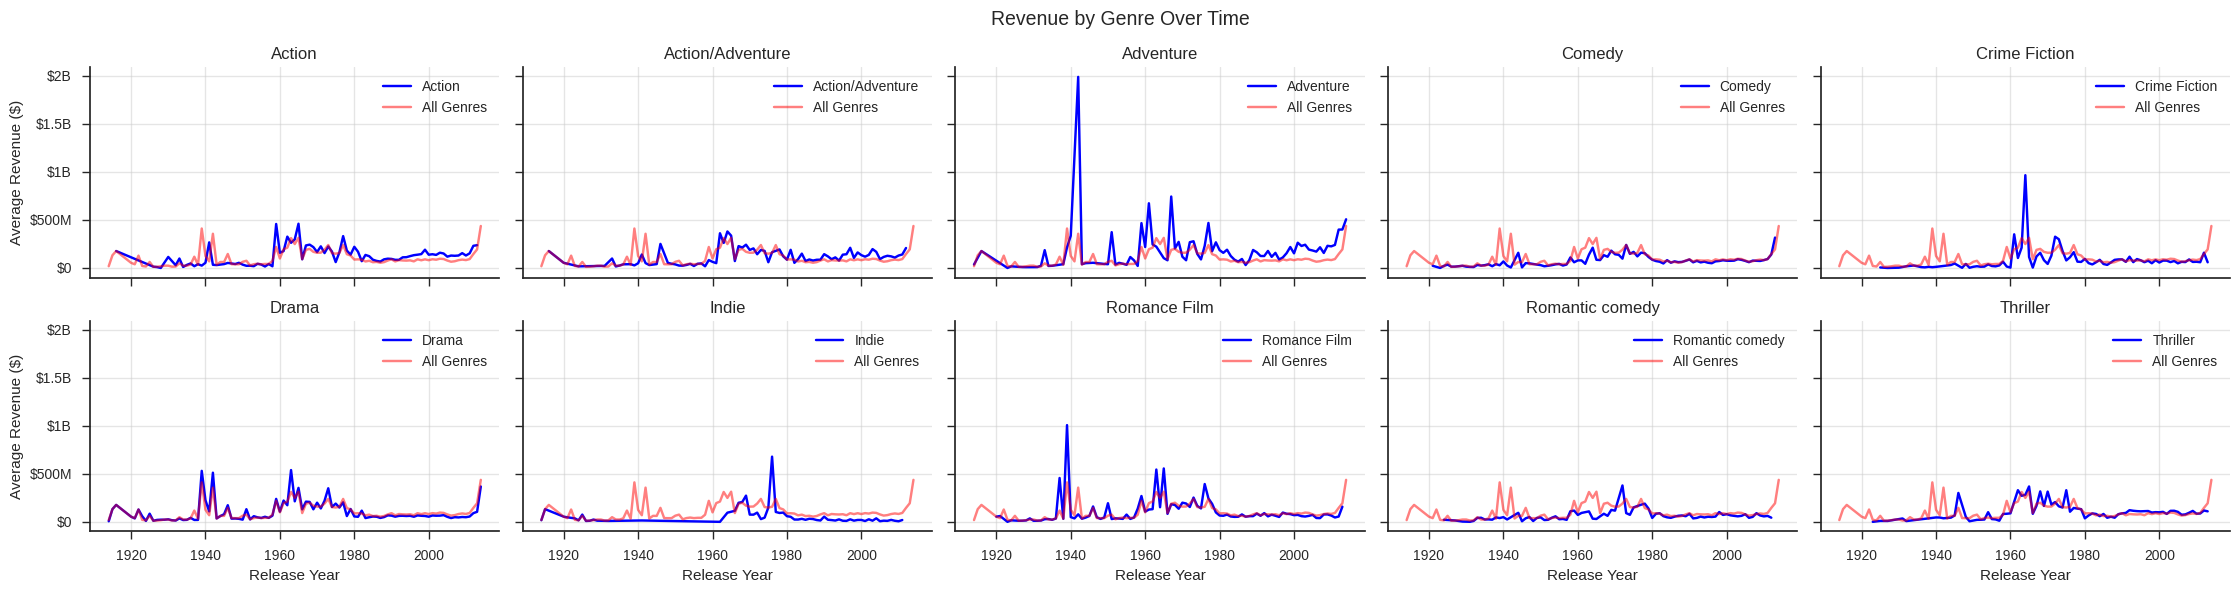

In [69]:
# calculate average revenue by year
year_avg_revenue = (
    df_genre_revenue.groupby("release_year")["inflated_revenue"].mean().reset_index()
)
# calculate average revenue by genre and year
genre_year_avg_revenue = (
    df_genre_revenue.groupby(["movie_genres", "release_year"])["inflated_revenue"]
    .mean()
    .reset_index()
)

# create a facet grid of line plots for each genre
g = sns.FacetGrid(
    data=genre_year_avg_revenue, col="movie_genres", col_wrap=5, height=3, aspect=1.5
)

for ax, genre in zip(g.axes, top_10_genres_list):
    revenue_data = genre_year_avg_revenue[
        genre_year_avg_revenue["movie_genres"] == genre
    ]
    ax.plot(
        revenue_data["release_year"],
        revenue_data["inflated_revenue"],
        color="blue",
        label=f"{genre}",
    )
    ax.plot(
        year_avg_revenue["release_year"],
        year_avg_revenue["inflated_revenue"],
        color="red",
        alpha=0.5,
        label="All Genres",
    )
    ax.set_xlabel("Release Year")
    ax.set_ylabel("Average Revenue ($)")
    ax.yaxis.set_major_formatter(plt.FuncFormatter(revenue_formatter))
    ax.tick_params(axis="y")
    ax.grid(True, alpha=0.5)
    ax.set_title(genre)
    ax.legend(loc="upper right")

plt.suptitle("Revenue by Genre Over Time", fontsize=14)
plt.tight_layout()
plt.show()

# TODO: What happened with Adventure movies around the 1940s?

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

</div>


### Are there any trends in genre popularity over time, and how do they correlate with revenue changes?

This question aims to determine if changes in revenue for a genre correspond with changes in the number of movies produced in that genre.


<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>
  - Visualization: Line plot
  - Correlation coefficient: Pearson and Spearman
</div>

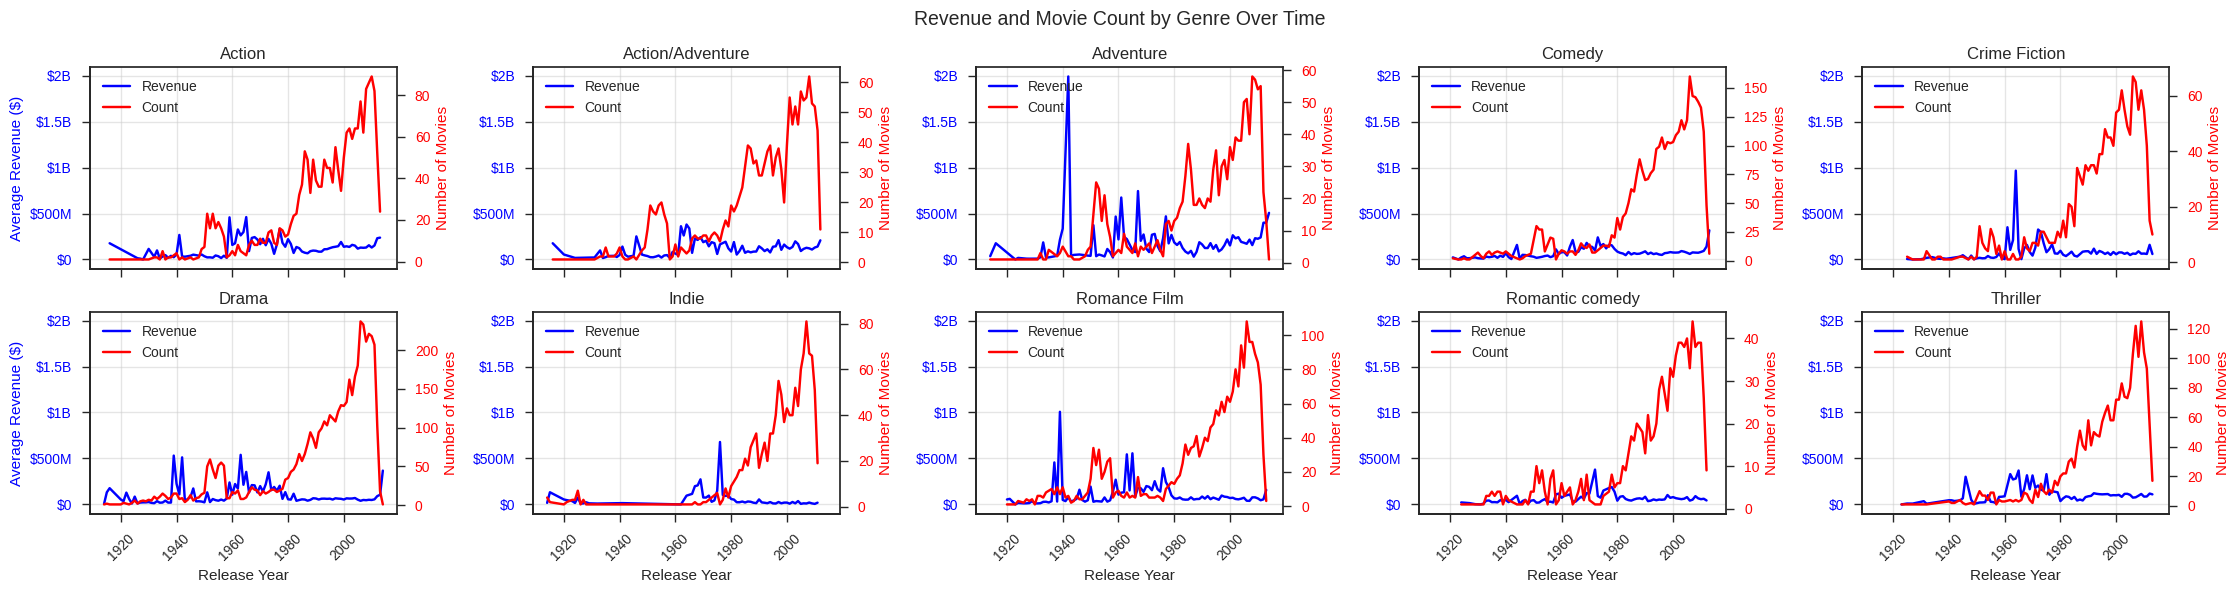

In [70]:
# TODO: Is it a good idea to only count movies that have a revenue?
# TODO: Explain the drop in the number of movies after 2000.

# calculate number of movies per genre per year
genre_year_counts = (
    df_genre_revenue.groupby(["movie_genres", "release_year"])
    .size()
    .reset_index(name="count")
)
# create a facet grid of line plots for each genre
g = sns.FacetGrid(
    data=genre_year_avg_revenue, col="movie_genres", col_wrap=5, height=3, aspect=1.5
)

# plot revenue on primary y-axis
for ax, genre in zip(g.axes, genre_year_avg_revenue["movie_genres"].unique()):
    # revenue plot
    revenue_data = genre_year_avg_revenue[
        genre_year_avg_revenue["movie_genres"] == genre
    ]
    ax1 = ax
    ln1 = ax1.plot(
        revenue_data["release_year"],
        revenue_data["inflated_revenue"],
        color="blue",
        label="Revenue",
    )
    ax1.set_xlabel("Release Year")
    ax1.set_ylabel("Average Revenue ($)", color="blue")
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(revenue_formatter))
    ax1.tick_params(axis="y", labelcolor="blue")

    # number of movies plot
    ax2 = ax1.twinx()
    count_data = genre_year_counts[genre_year_counts["movie_genres"] == genre]
    ln2 = ax2.plot(
        count_data["release_year"], count_data["count"], color="red", label="Count"
    )
    ax2.set_ylabel("Number of Movies", color="red")
    ax2.tick_params(axis="y", labelcolor="red")

    # formatting
    ax1.tick_params(axis="x", rotation=45)
    ax1.grid(True, alpha=0.5)
    ax.set_title(genre)

    # legend
    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc="upper left")

plt.suptitle("Revenue and Movie Count by Genre Over Time", fontsize=14)
plt.tight_layout()
plt.show()

In [71]:
results = []  # empty list to store the results
for genre in top_10_genres_list:
    # extract average log revenue for the genre
    genre_average_revenue = np.log10(
        genre_year_avg_revenue[genre_year_avg_revenue["movie_genres"] == genre][
            "inflated_revenue"
        ]
    )
    # extract number of movies for the genre
    genre_count = genre_year_counts[genre_year_counts["movie_genres"] == genre]["count"]
    # calculate Pearson and Spearman correlation coefficients
    pearson_correlation, pearson_p_value = stats.pearsonr(
        genre_average_revenue, genre_count
    )
    spearman_correlation, spearman_p_value = stats.spearmanr(
        genre_average_revenue, genre_count
    )
    # append the results to the list
    results.append(
        {
            "Genre": genre,
            "Pearson Correlation": f"{pearson_correlation:.2f}",
            "Pearson p-value": f"{pearson_p_value:.2f}",
            "Spearman Correlation": f"{spearman_correlation:.2f}",
            "Spearman p-value": f"{spearman_p_value:.2f}",
        }
    )

# convert the list of results to a dataframe
correlation_df = pd.DataFrame(results)
print(tabulate(correlation_df, headers="keys", tablefmt="psql", showindex=False))

+------------------+-----------------------+-------------------+------------------------+--------------------+
| Genre            |   Pearson Correlation |   Pearson p-value |   Spearman Correlation |   Spearman p-value |
|------------------+-----------------------+-------------------+------------------------+--------------------|
| Action           |                  0.24 |              0.02 |                   0.24 |               0.03 |
| Action/Adventure |                  0.24 |              0.03 |                   0.21 |               0.06 |
| Adventure        |                  0.23 |              0.04 |                   0.24 |               0.03 |
| Comedy           |                  0.22 |              0.04 |                   0.34 |               0    |
| Crime Fiction    |                  0.29 |              0.01 |                   0.39 |               0    |
| Drama            |                 -0.12 |              0.23 |                   0.01 |               0.89 |
|

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>


</div>

# Movie 4: Starlight 💫 
## To what extent is a movie's box office revenue influenced by its director?

</div> <div class="alert alert-success"> 🎞️ <strong>Movie Trailer:</strong>

**TODO:** Feel free to modify this.

This film aims to highlight which directors produce the most movies, which ones generate the highest total revenue and which ones achieve the best average revenue per movie.

**🏗️ Analysis Structure:**

- **Data Preparation**
  - Relevant columns
  - Handling missing values
  - Handling duplicates
  - ...
- **Exploratory Data Analysis**
  - ...
- ...
  - ...
- ...

**TODO:** I didn't try to organize your code, please follow the template and inspire yourself by the other sections. 
</div>

### Data Preparation

#### Relevant Columns

For this analysis, we’ll focus on the following columns:
*	`director`: Add description
*	`inflated_revenue`: The box office revenue adjusted for inflation.
*	`relase_year`: Add description
*   `movie_name`: Add description

#### Handling Missing Values

#### Handling Duplicates

### Exploratory Data Analysis

<div class="alert alert-success">

  💭 <strong>Idea:</strong>
  
  - Is the same director responsible for the top revenue movies each year?
  - Is it luck or skill? Does a director that produced a top revenue movie once, do it again?
  - Does the director's get better with time?

</div>
<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>
  - Exploration of the director column
    - The average revenue of the director's movies ?
    - The total revenue of the director's movies ?
    - The revenue of the director's most successful movie ?
  - Analyse the top revenue movies and director
    - Does the top revenue movies each year have the same director?
    - What about if we consider the top 5 revenue movies?
  - Does the director's get better with time?
    - Analyse the average revenue of the director's movies over time 
      - for directors that produced the most movies
      - for directors that produced the most revenue
      - for directors that produced the most successful movies
      - for directors that produced the most average revenue movie
</div>

### Exploration of the director column

In [72]:
df_dir = df[["director", "inflated_revenue", "release_year", "movie_name"]]
df_dir.head()

director  inflated_revenue  release_year                movie_name
0    John Carpenter      1.899115e+07        2001.0            Ghosts of Mars
1        Henry King      6.812740e+07        1938.0  Alexander's Ragtime Band
2   Kenneth Branagh      1.967252e+07        1989.0                   Henry V
3  Robert Stevenson      7.913870e+08        1964.0              Mary Poppins
4           Unknown      3.100822e+04        1999.0            New Rose Hotel

In [73]:
df_dir = df_dir[df_dir["director"] != "Unknown"]  # remove rows with unknown directors

In [74]:
df_dir["director"].nunique()  # number of unique directors

3258

#### What is the highest inflated revenue each year?

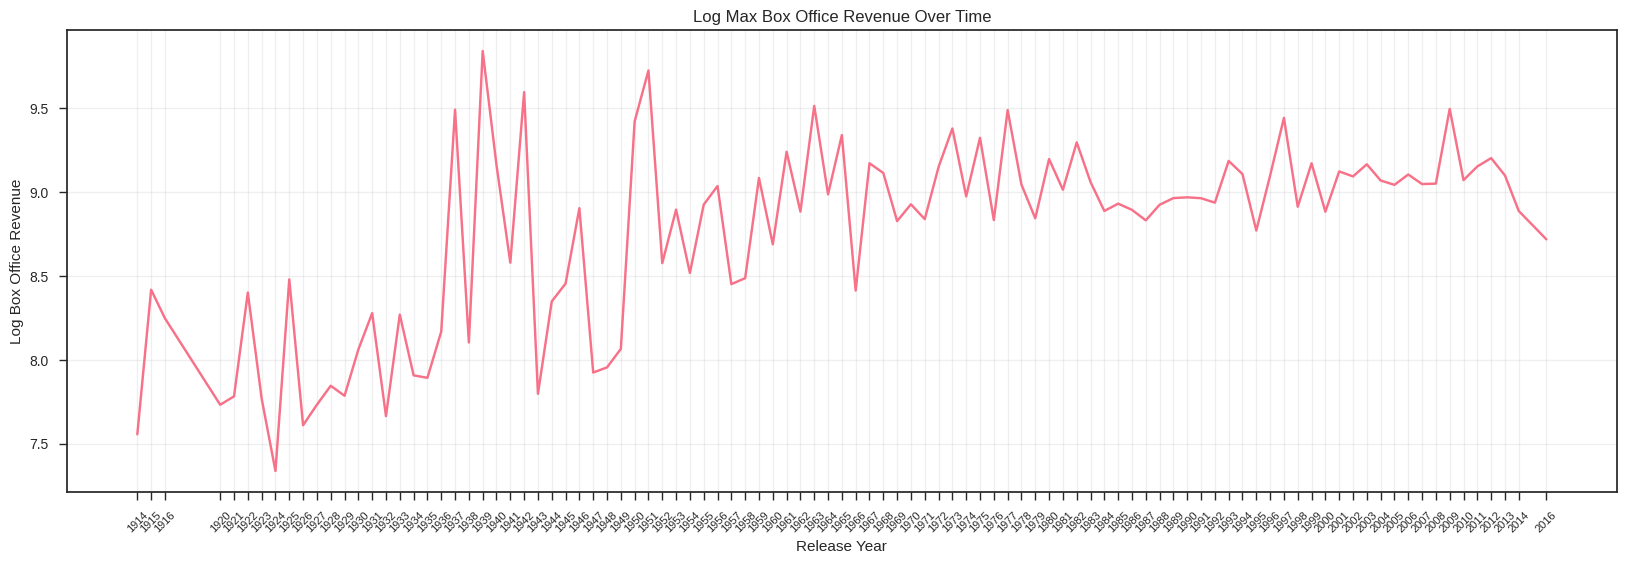

In [75]:
plt.figure(figsize=(20, 6))
yearly_inflated_avg = df.groupby("release_year")["inflated_revenue"].max()
yearly_inflated_avg = np.log10(yearly_inflated_avg)
sns.lineplot(x=yearly_inflated_avg.index, y=yearly_inflated_avg.values)
plt.title("Log Max Box Office Revenue Over Time")
plt.xlabel("Release Year")
plt.ylabel("Log Box Office Revenue")
plt.xticks(yearly_inflated_avg.index, rotation=45, fontsize=8)
plt.grid(True, alpha=0.3)
plt.show()

In [76]:
df_dir[
    df_dir["inflated_revenue"] == df_dir["inflated_revenue"].max()
]  # director with the highest inflated revenue movie

director  inflated_revenue  release_year          movie_name
4499  Victor Fleming      6.905588e+09        1939.0  Gone with the Wind

In [77]:
df_dir[df_dir["director"] == "Victor Fleming"]  # Victor Fleming's movies

director  inflated_revenue  release_year               movie_name
484   Victor Fleming      5.824878e+08        1939.0         The Wizard of Oz
2362  Victor Fleming      5.758317e+07        1948.0              Joan of Arc
4499  Victor Fleming      6.905588e+09        1939.0       Gone with the Wind
5004  Victor Fleming      2.087435e+07        1934.0          Treasure Island
7438  Victor Fleming      2.084680e+07        1941.0  Dr. Jekyll and Mr. Hyde

#### Which directors generate the most revenue?

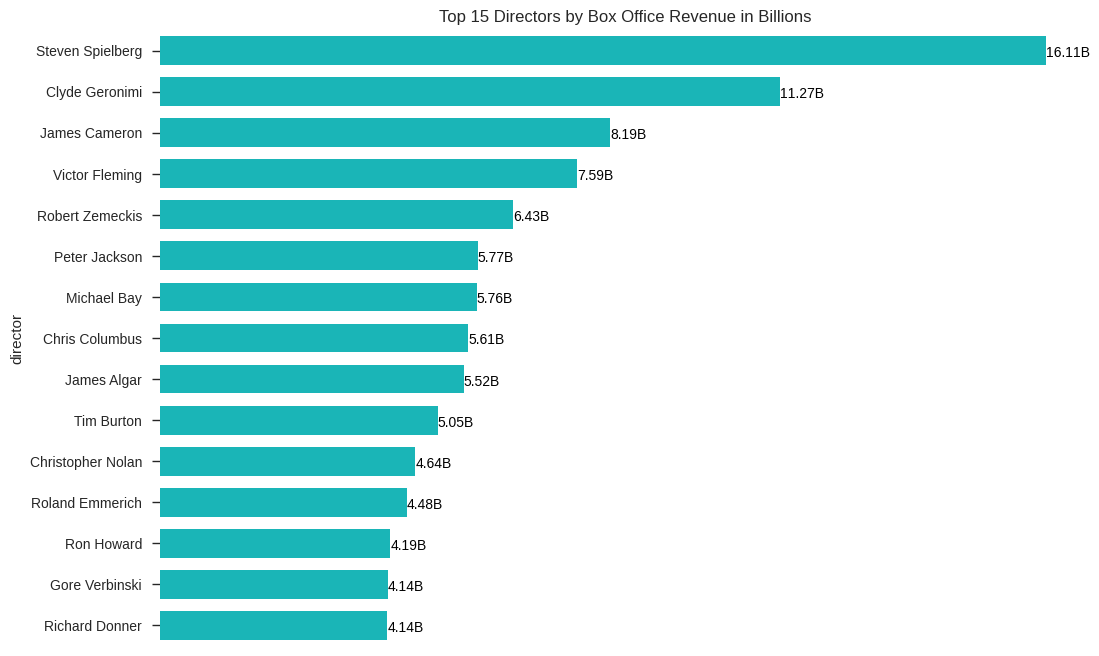

In [78]:
df_top_dir = (
    df_dir.groupby("director")
    .sum()
    .sort_values(by="inflated_revenue", ascending=False)
    .head(15)
)
df_top_dir.reset_index(inplace=True)
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    y="director", x="inflated_revenue", data=df_top_dir, width=0.7, color="#00CED1"
)
# hide x axis
ax.xaxis.set_visible(False)
# put the inflated revenue on the right side of the bar in billions
ax.set_title("Top 15 Directors by Box Office Revenue in Billions")
for i in ax.patches:
    ax.text(
        i.get_width() + 0.5,
        i.get_y() + 0.5,
        str(round(i.get_width() / 1e9, 2)) + "B",
        fontsize=10,
        color="black",
    )
plt.box(False)

#### Which directors produce the most movies?

Text(0.5, 1.0, 'Top 15 Directors by Number of Movies')

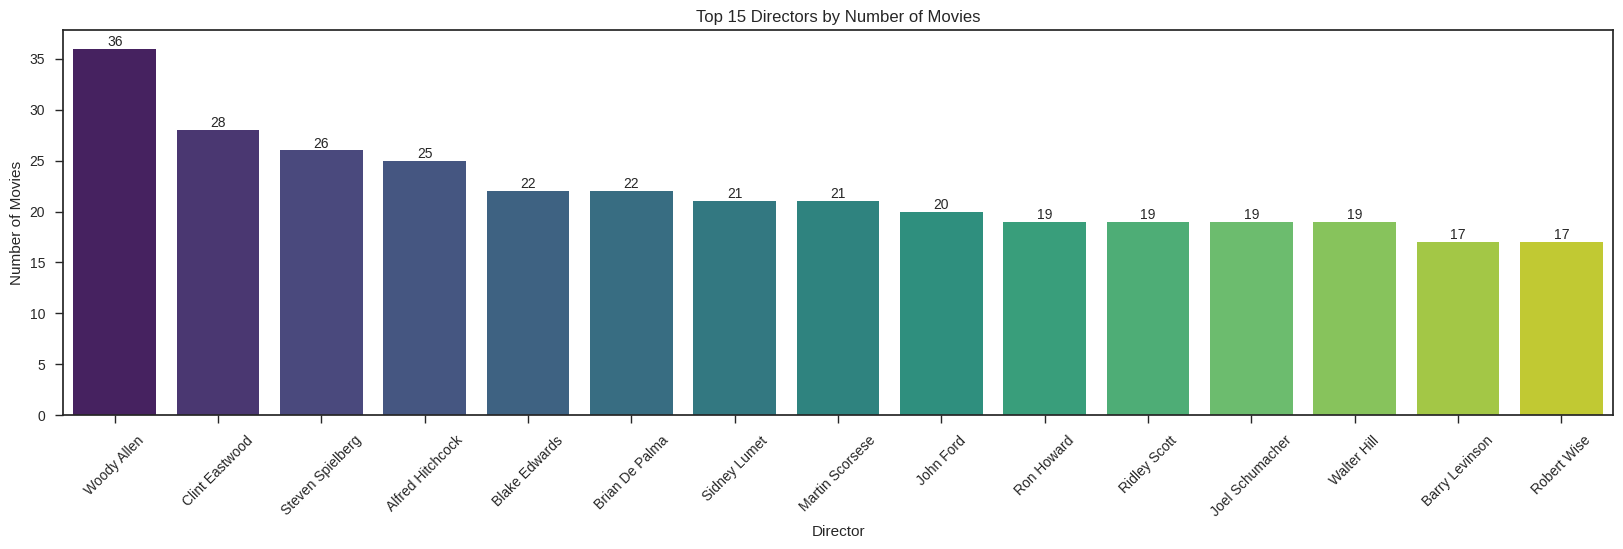

In [79]:
# plot top 10 directors by number of movies
df_count = df_dir["director"].value_counts().head(15)
plt.figure(figsize=(20, 5))
# add numbers above bars
ax = sns.barplot(x=df_count.index, y=df_count.values, palette="viridis")
for container in ax.containers:
    ax.bar_label(container)
plt.xticks(rotation=45)
plt.xlabel("Director")
plt.ylabel("Number of Movies")
plt.title("Top 15 Directors by Number of Movies")

#### Who generated the best average revenue per movie?

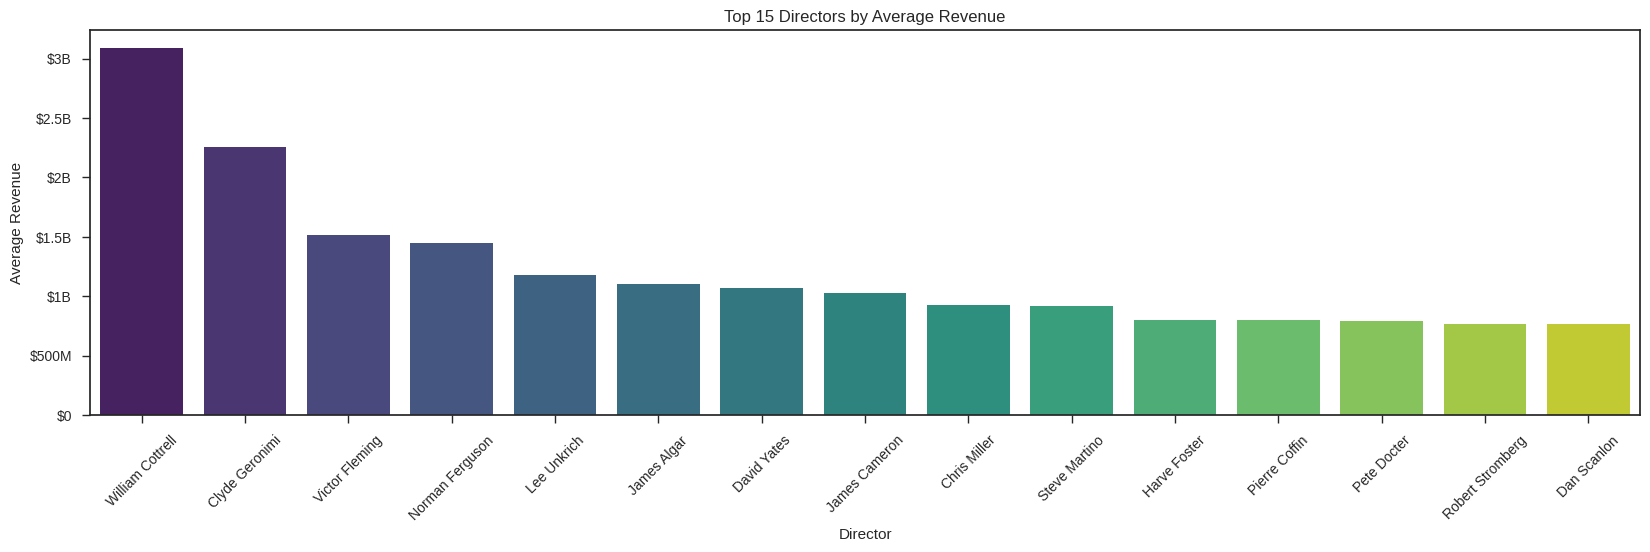

In [80]:
# plot top 15 revenue generating directors average revenue
df_mean = (
    df_dir[["director", "inflated_revenue"]]
    .groupby("director")
    .mean()
    .sort_values(by="inflated_revenue", ascending=False)
    .head(15)
)
plt.figure(figsize=(20, 5))
# add numbers above bars
ax = sns.barplot(x=df_mean.index, y=df_mean["inflated_revenue"], palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Director")
plt.ylabel("Average Revenue")
plt.title("Top 15 Directors by Average Revenue")
plt.gca().yaxis.set_major_formatter(revenue_formatter)
plt.show()

### Analyse the top revenue movies and director

In [81]:
# Sort the dataset by year and inflated_revenue in descending order
df_sorted = df_dir.sort_values(
    by=["release_year", "inflated_revenue"], ascending=[True, False]
)

# Extract the top movie for each year
top_movies_per_year = df_sorted.groupby("release_year").first().reset_index()

# Show the result (one movie per year with the highest revenue)
top_movies_per_year.head(15)

release_year            director  inflated_revenue  \
0         1914.0         Oscar Apfel      5.863203e+06   
1         1915.0       D.W. Griffith      2.611785e+08   
2         1916.0        Stuart Paton      1.764218e+08   
3         1920.0       D.W. Griffith      5.388934e+07   
4         1921.0          Rex Ingram      6.050601e+07   
5         1922.0  Erich von Stroheim      5.734380e+06   
6         1923.0    Cecil B. DeMille      5.868267e+07   
7         1924.0    Fred C. Newmeyer      2.172328e+07   
8         1925.0          King Vidor      3.010066e+08   
9         1926.0      Clyde Bruckman      1.355973e+07   
10        1927.0       Alan Crosland      5.392384e+07   
11        1928.0       Frank Borzage      2.377924e+07   
12        1929.0      Harry Beaumont      6.095879e+07   
13        1930.0       Howard Hughes      1.149735e+08   
14        1931.0         James Whale      1.893755e+08   

                             movie_name  
0                         The Squaw Man  
1                 The Birth of a Nation  
2          20,000 Leagues Under the Sea  
3                         Way Down East  
4   The Four Horsemen of the Apocalypse  
5                         Foolish Wives  
6                  The Ten Commandments  
7                              Girl Shy  
8                        The Big Parade  
9                           The General  
10                      The Jazz Singer  
11                         Street Angel  
12                  The Broadway Melody  
13                        Hell's Angels  
14                         Frankenstein

In [82]:
# Count the occurrences of directors in the top revenue movies
director_counts = Counter(top_movies_per_year["director"])

# Display directors who appear multiple times in the top revenue movies
repeated_directors = {
    director: count for director, count in director_counts.items() if count > 1
}
print("Directors with multiple top revenue movies across years:", repeated_directors)

Directors with multiple top revenue movies across years: {'D.W. Griffith': 2, 'Cecil B. DeMille': 4, 'Frank Capra': 2, 'Leo McCarey': 2, 'Clyde Geronimi': 5, 'Guy Hamilton': 2, 'George Roy Hill': 2, 'Steven Spielberg': 6, 'John Glen': 2, 'James Cameron': 3, 'Michael Bay': 2, 'Peter Jackson': 2, 'Gore Verbinski': 2}


In [83]:
# Identify consecutive years with the same director
top_movies_per_year["same_director_as_last_year"] = top_movies_per_year[
    "director"
] == top_movies_per_year["director"].shift(1)

# Filter for years where the same director repeated
consecutive_director_years = top_movies_per_year[
    top_movies_per_year["same_director_as_last_year"]
]
print("Consecutive years with the same director:\n", consecutive_director_years)

Consecutive years with the same director:
     release_year        director  inflated_revenue  \
28        1945.0     Leo McCarey      2.841400e+08   
34        1951.0  Clyde Geronimi      5.288633e+09   
86        2003.0   Peter Jackson      1.459795e+09   
90        2007.0  Gore Verbinski      1.112396e+09   

                                       movie_name  same_director_as_last_year  
28                        The Bells of St. Mary's                        True  
34                            Alice in Wonderland                        True  
86  The Lord of the Rings: The Return of the King                        True  
90       Pirates of the Caribbean: At World's End                        True  


In [84]:
# Get the director with the maximum count
most_frequent_director = max(repeated_directors, key=repeated_directors.get)
print("Director with the most top revenue movies:", most_frequent_director)

Director with the most top revenue movies: Steven Spielberg


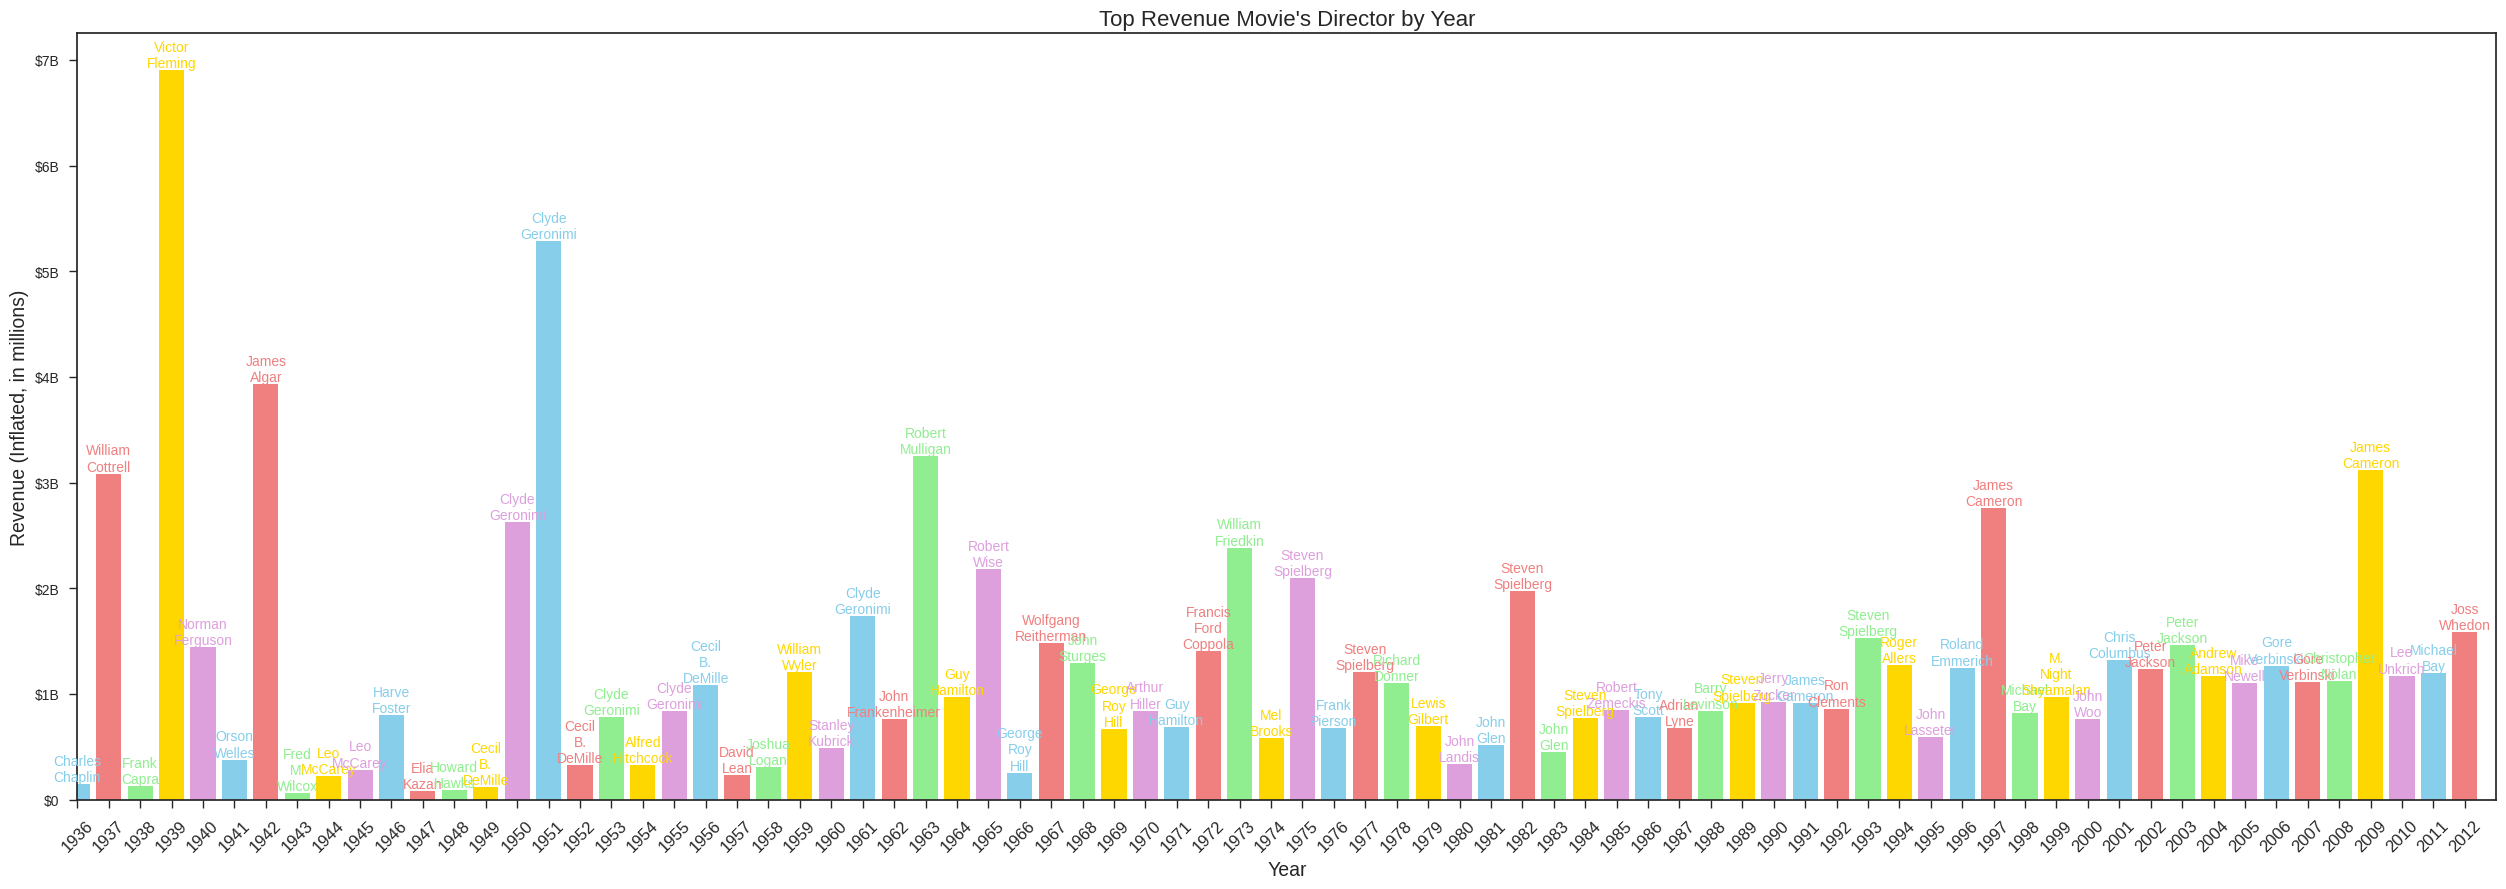

In [85]:
# Modify the director names to split into first and last names on two lines
top_movies_per_year = top_movies_per_year[
    (top_movies_per_year["release_year"] >= 1936)
    & (top_movies_per_year["release_year"] <= 2012)
]  # Filter dataset to plot a manageable range of years
top_movies_per_year["director"] = top_movies_per_year["director"].apply(
    lambda x: "\n".join(x.split(" "))
)

# Generate a color palette for diversity
colors = ["skyblue", "lightcoral", "lightgreen", "gold", "plum"]
bar_colors = [colors[i % len(colors)] for i in range(len(top_movies_per_year))]

# Plot the bar chart
plt.figure(figsize=(25, 9))
bars = plt.bar(
    top_movies_per_year["release_year"],
    top_movies_per_year["inflated_revenue"],
    color=bar_colors,
    width=0.8,  # Increase the width of the bars
)

# Adding director names as labels on top of each bar with alternating heights
for i, (bar, label, color) in enumerate(
    zip(bars, top_movies_per_year["director"], bar_colors)
):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # Center text horizontally on the bar
        bar.get_height() + (50 if i % 2 == 0 else 120),  # It is not working
        label,
        ha="center",
        va="bottom",
        fontsize=10,
        color=color,  # Match label color with bar color
    )

# Titles and labels
plt.title("Top Revenue Movie's Director by Year", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Revenue (Inflated, in millions)", fontsize=14)
plt.xlim(1936, 2013)
plt.xticks(top_movies_per_year["release_year"], rotation=45, fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(revenue_formatter)
plt.show()

In [86]:
## TODO
# - Finish plotting other questions
# - Add comments and explanations

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>


</div>

### Analysis

<div class="alert alert-success">

  💭 <strong>Idea:</strong>

  
</div>
<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>

</div>

#### Is each year's highest revenue movie directed by the same director?

<Figure size 2000x1500 with 0 Axes>

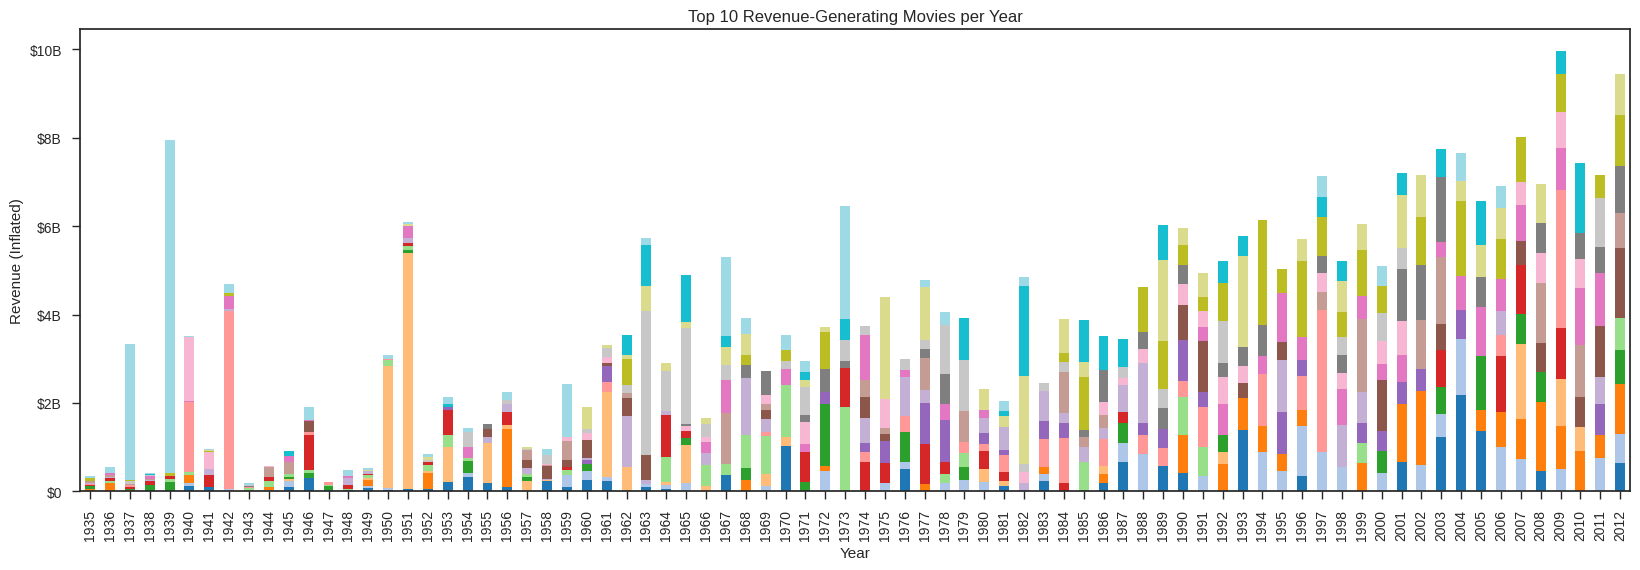

In [87]:
# Group by year and get the top 3 movies by revenue per year without sorting
df_dir_reduced_year = df_dir[
    (df_dir["release_year"] >= 1935) & (df_dir["release_year"] <= 2012)
]  # cleaner data
df_dir_reduced_year["release_year"] = df_dir_reduced_year["release_year"].astype(int)
top = 10
df_top = (
    df_dir_reduced_year.groupby("release_year")
    .apply(lambda x: x.nlargest(top, "inflated_revenue"))
    .reset_index(drop=True)
)

# Grouping and preparing data for plotting
yearly_director_revenue = (
    df_top.groupby(["release_year", "director"])["inflated_revenue"]
    .sum()
    .unstack(fill_value=0)
)
# For each year I want the to get the director with the highest revenue and sort the columns by that
# Code Here
# Find the top director per year (the one with the highest revenue)
top_director_per_year = yearly_director_revenue.idxmax(axis=1)


# Plotting
plt.figure(figsize=(20, 15))

# Prepare the data for plotting: reorder so that the top director's revenue comes first
yearly_director_revenue_sorted = yearly_director_revenue.apply(
    lambda row: row.sort_values(ascending=False), axis=1
)

# Plotting with stacked bars
ax = yearly_director_revenue_sorted.plot(
    kind="bar", stacked=True, figsize=(20, 6), cmap="tab20"
)


# Customize the plot
plt.title(f"Top {top} Revenue-Generating Movies per Year")
plt.xlabel("Year")
plt.ylabel("Revenue (Inflated)")

# Remove the legend
ax.legend().remove()
plt.gca().yaxis.set_major_formatter(revenue_formatter)
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>


</div>

# Movie 5: Waves 🌊 
## How much is a movie’s box office revenue influenced by its release timing and duration?

</div> <div class="alert alert-success"> 🎞️ <strong>Movie Trailer:</strong>

**TODO:** Feel free to rewrite this.

This film aims to provide insights into the influence of a movie’s release season on its success. It also examines the impact of the movie’s runtime for each season individually and breaks down these factors by genre.

**🏗️ Analysis Structure:**

- **Data Preparation**
  - Relevant columns
  - Handling missing values
  - Handling duplicates
  - Defining seasons
  - ...
- **Exploratory Data Analysis**
  - ...
- ...


</div>

### Data Preparation

#### Relevant Columns
For this analysis, we’ll focus on the following columns:
*	`movie_release_date`: Add description
*	TODO: Add the other colums with descriptions

In [88]:
# select relevant columns
df_season = df[
    [
        "movie_release_date",
        "inflated_revenue",
        "release_day",
        "release_month",
        "release_year",
        "movie_genres",
        "movie_runtime",
    ]
]

df_season.head()

movie_release_date  inflated_revenue  release_day  release_month  \
0         2001-08-24      1.899115e+07         24.0            8.0   
1         1938-08-16      6.812740e+07         16.0            8.0   
2         1989-11-08      1.967252e+07          8.0           11.0   
3         1964-08-27      7.913870e+08         27.0            8.0   
4         1999-10-01      3.100822e+04          1.0           10.0   

   release_year                                       movie_genres  \
0        2001.0  [('/m/01jfsb', 'Thriller'), ('/m/06n90', 'Scie...   
1        1938.0  [('/m/04t36', 'Musical'), ('/m/01z4y', 'Comedy...   
2        1989.0  [('/m/04xvh5', 'Costume drama'), ('/m/082gq', ...   
3        1964.0  [('/m/0hj3myq', "Children's/Family"), ('/m/04t...   
4        1999.0  [('/m/01jfsb', 'Thriller'), ('/m/06n90', 'Scie...   

   movie_runtime  
0           98.0  
1          106.0  
2          137.0  
3          139.0  
4           92.0

#### Handling missing values

In [89]:
# Check for missing values
print(df_season.isnull().sum())

# Drop rows with missing revenue or runtime
df_season = df_season.dropna(subset=["inflated_revenue", "movie_runtime"])

movie_release_date      0
inflated_revenue        0
release_day             0
release_month           0
release_year            0
movie_genres            0
movie_runtime         185
dtype: int64


#### Handling duplicates

#### Defining seasons

In [90]:
def assign_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    elif month in [9, 10, 11]:
        return "Fall"
    else:
        return np.nan  # Handle missing or invalid months


df_season["season"] = df_season["release_month"].apply(assign_season)

#### Ensuring numeric inputs

In [91]:
df_season["inflated_revenue"] = pd.to_numeric(df_season["inflated_revenue"])
df_season["movie_runtime"] = pd.to_numeric(df_season["movie_runtime"])
df_season["log_revenue"] = np.log10(df_season["inflated_revenue"])

### Analysis

<div class="alert alert-success">

  💭 <strong>Idea:</strong>
  - Are the revenues and the popularities of genres affected by the season of the year?
  - Is the movie runtime affected by the season, and does it have any affect on revenue?

  
</div>
<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>

  - Distribution plots, bar plots, scatter plots

</div>

Histogram showing how movie revenues are distributed across all movies

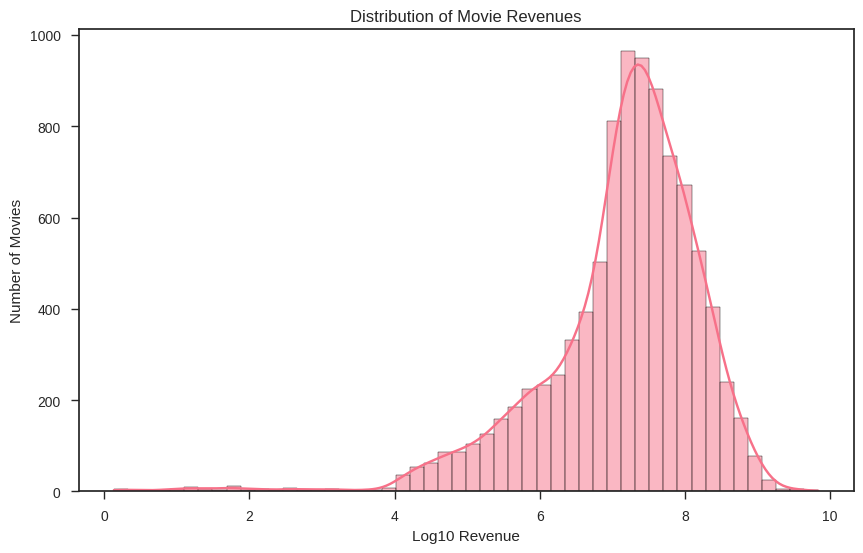

In [92]:
plt.figure(figsize=(10, 6))
sns.histplot(df_season["log_revenue"], bins=50, kde=True)
plt.title("Distribution of Movie Revenues")
plt.xlabel("Log10 Revenue")
plt.ylabel("Number of Movies")
plt.show()

Bar plot comparing the average revenue of movies released in different seasons

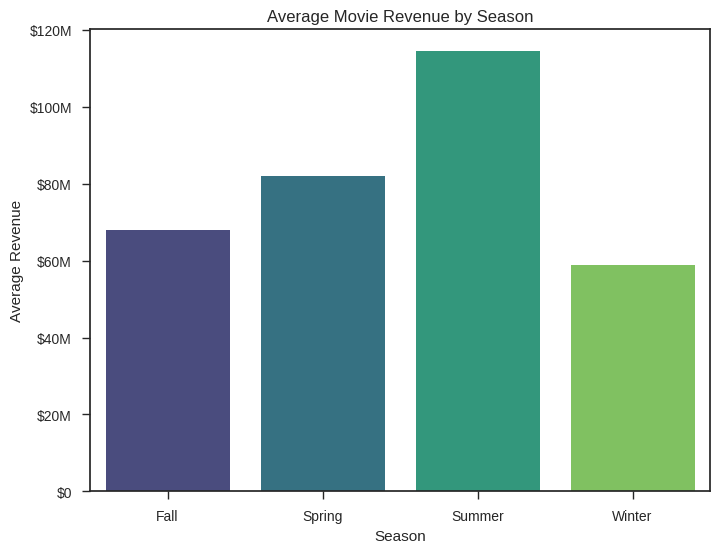

In [93]:
season_revenue = df_season.groupby("season")["inflated_revenue"].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x="season", y="inflated_revenue", data=season_revenue, palette="viridis")
plt.title("Average Movie Revenue by Season")
plt.xlabel("Season")
plt.ylabel("Average Revenue")
plt.gca().yaxis.set_major_formatter(revenue_formatter)
plt.show()

Scatter plot showing the relationship between movie duration and revenue, with points colored by season

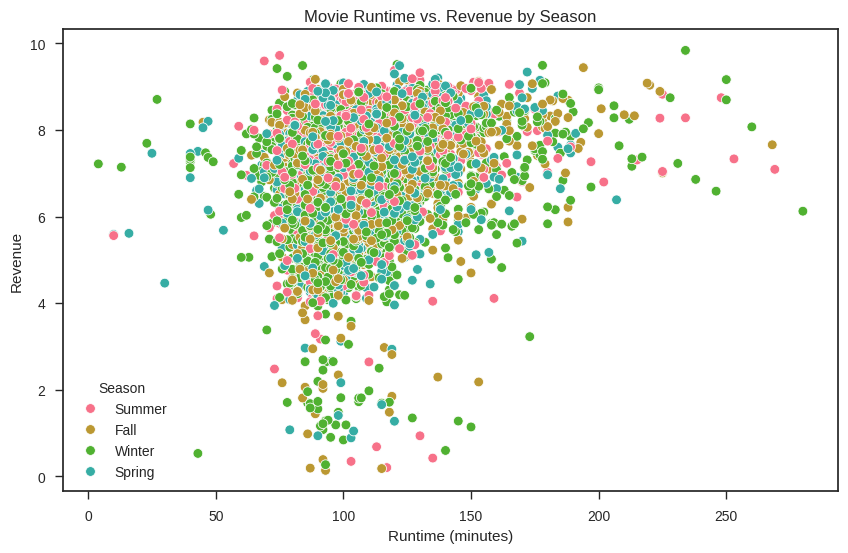

In [94]:
# filtered df_season to remove outlier movies with runtime > 300 minutes
df_season_filtered = df_season[df_season["movie_runtime"] <= 300]
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="movie_runtime", y="log_revenue", hue="season", data=df_season_filtered
)
plt.title("Movie Runtime vs. Revenue by Season")
plt.xlabel("Runtime (minutes)")
plt.ylabel("Revenue")
plt.legend(title="Season")
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>
  
  - The initial observations show that the summer movies have higher revenue.
    

</div>

#### Genre analysis

<div class="alert alert-success">

  💭 <strong>Idea:</strong>
  - How does the genre affect the revenue?
  - Does the season affect the revenue and the genre?
  - Does the release day of the week have any affect on the revenue?
  - Did the genre popularity change over the years?
  
</div>
<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>
  - Bar graps, heatmaps, scatter plots

</div>

Top 10 genres by revenue

In [95]:
# Convert the string representation to an actual list
df_genres_and_season = df_season.copy()

# First, ensure that the 'movie_genres' column is not null
df_genres_and_season = df_genres_and_season[
    df_genres_and_season["movie_genres"].notna()
]

# Apply ast.literal_eval to convert strings to lists
df_genres_and_season["movie_genres"] = df_genres_and_season["movie_genres"].apply(
    ast.literal_eval
)

# Now extract the genre names
df_genres_and_season["movie_genres"] = df_genres_and_season["movie_genres"].apply(
    lambda x: [genre[1] for genre in x]
)

# Explode the genres
df_genres_and_season = df_genres_and_season.explode("movie_genres")

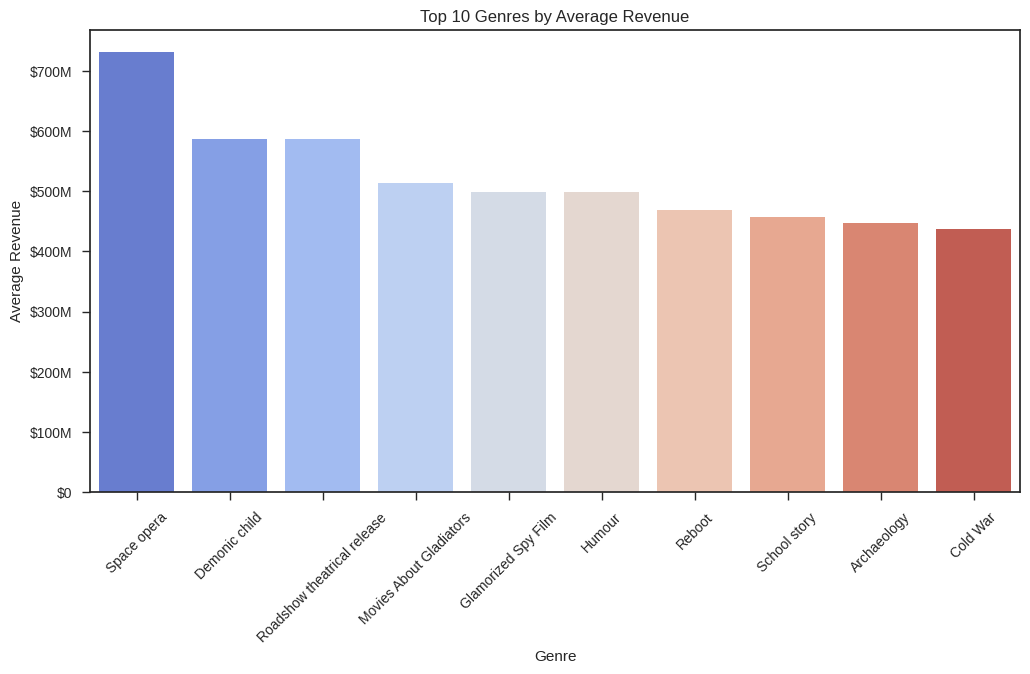

In [96]:
genre_revenue = (
    df_genres_and_season.groupby("movie_genres")["inflated_revenue"]
    .mean()
    .reset_index()
)
top_genres = genre_revenue.sort_values("inflated_revenue", ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x="movie_genres", y="inflated_revenue", data=top_genres, palette="coolwarm")
plt.title("Top 10 Genres by Average Revenue")
plt.xlabel("Genre")
plt.ylabel("Average Revenue")
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(revenue_formatter)
plt.show()

Revenue based on season and genre

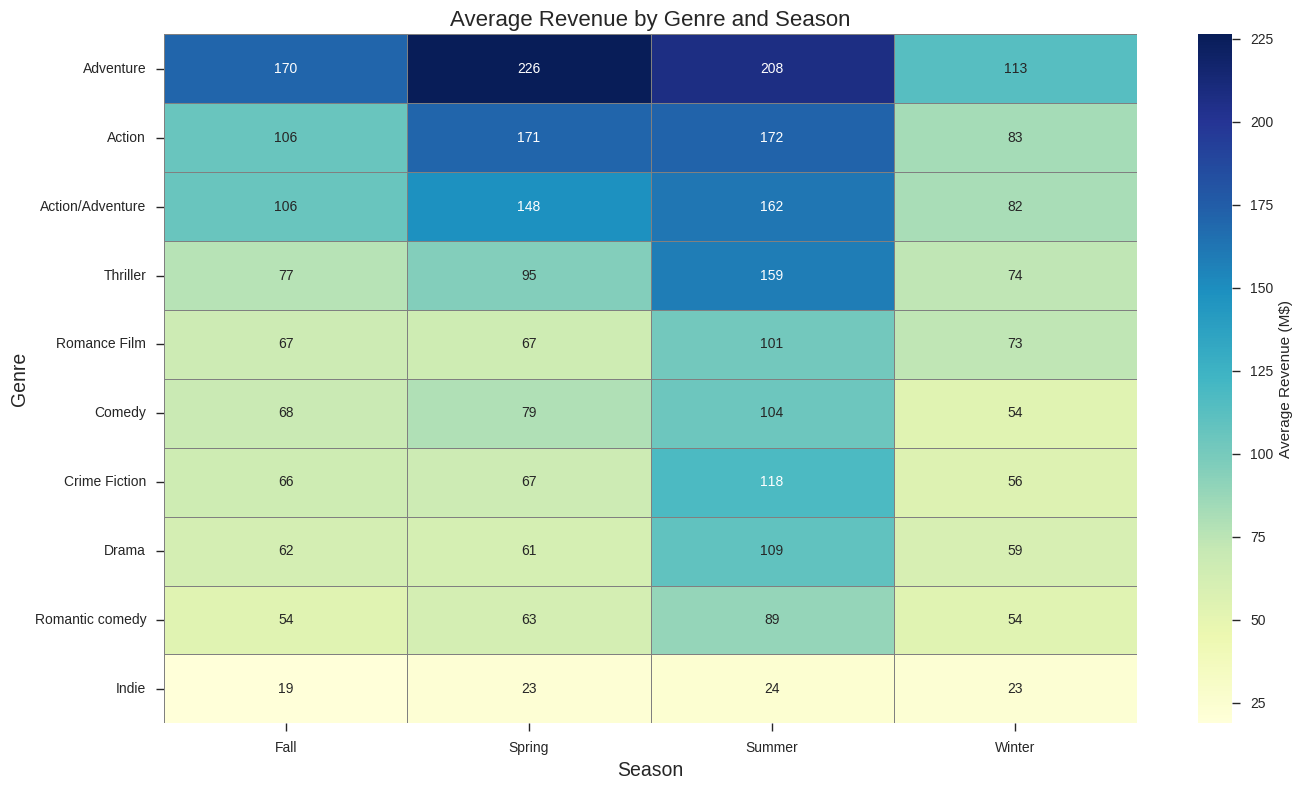

In [97]:
# Convert string representation to actual list
df_genres_and_season = df_season.copy()
df_genres_and_season["movie_genres"] = df_genres_and_season["movie_genres"].apply(
    ast.literal_eval
)
df_genres_and_season["movie_genres"] = df_genres_and_season["movie_genres"].apply(
    lambda x: [genre[1] for genre in x]
)
df_genres_and_season = df_genres_and_season.explode("movie_genres")

# Get top 10 genres by frequency
top_genres_list = (
    df_genres_and_season["movie_genres"].value_counts().head(10).index.tolist()
)
df_top_genres = df_genres_and_season[
    df_genres_and_season["movie_genres"].isin(top_genres_list)
]

pivot_table = df_top_genres.pivot_table(
    values="inflated_revenue",
    index="movie_genres",
    columns="season",
    aggfunc="mean",
)

# Calculate average revenue per genre
genre_revenue = (
    df_top_genres.groupby("movie_genres")["inflated_revenue"].mean().reset_index()
)
sorted_genres = genre_revenue.sort_values("inflated_revenue", ascending=False)[
    "movie_genres"
]

# Reorder the pivot table
pivot_table = pivot_table.reindex(index=sorted_genres)

plt.figure(figsize=(14, 8))
sns.heatmap(
    pivot_table / 1e6,  # Convert to millions
    annot=True,
    fmt=".0f",
    cmap="YlGnBu",
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={"label": "Average Revenue (M$)"},
)
plt.title("Average Revenue by Genre and Season", fontsize=16)
plt.xlabel("Season", fontsize=14)
plt.ylabel("Genre", fontsize=14)
plt.yticks(rotation=0)  # Keep genre labels horizontal
plt.xticks(rotation=0)  # Keep season labels horizontal
plt.tight_layout()

plt.show()

Alternative representation 1

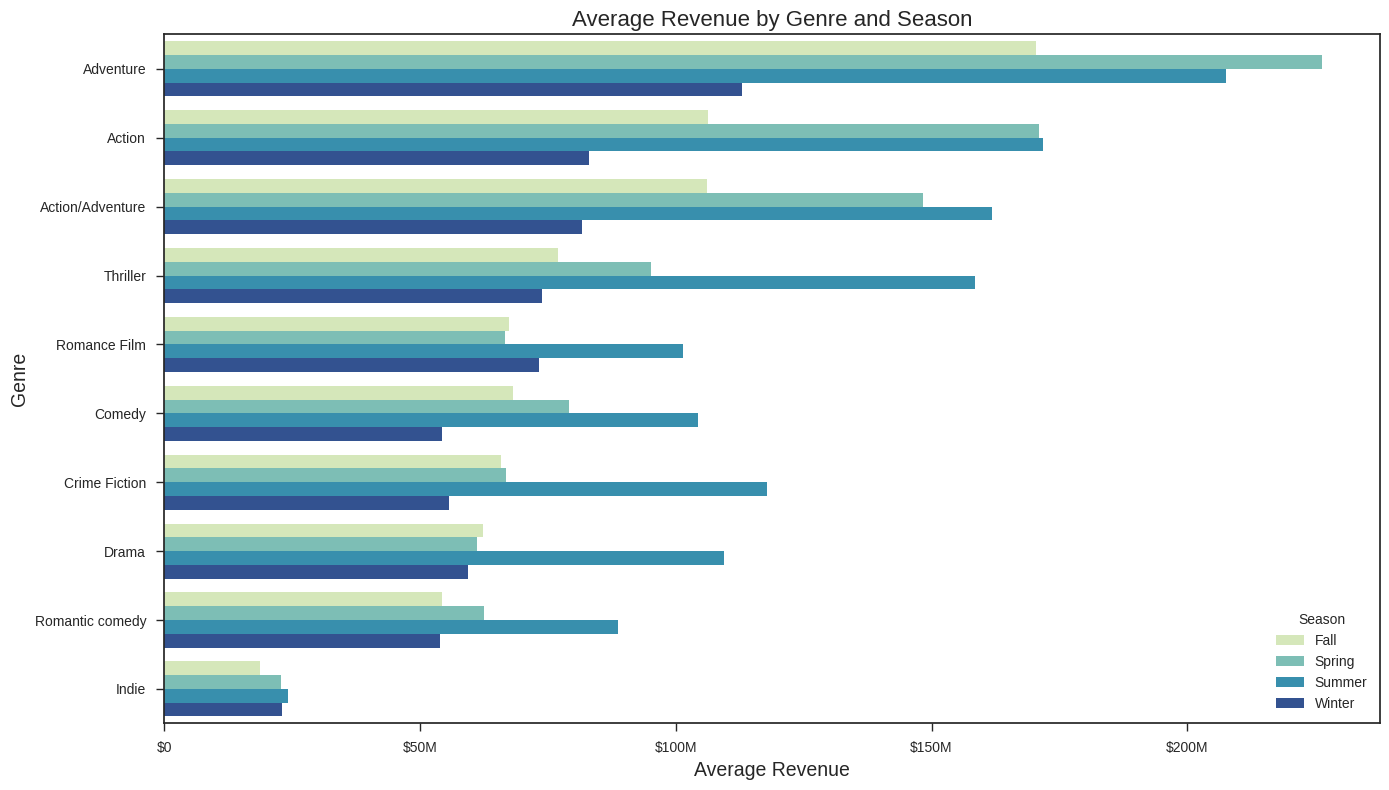

In [98]:
# Reset index for plotting
pivot_table_reset = pivot_table.reset_index().melt(
    id_vars="movie_genres", var_name="Season", value_name="Average Revenue"
)

plt.figure(figsize=(14, 8))
sns.barplot(
    x="Average Revenue",
    y="movie_genres",
    hue="Season",
    data=pivot_table_reset,
    palette="YlGnBu",
)
plt.title("Average Revenue by Genre and Season", fontsize=16)
plt.xlabel("Average Revenue", fontsize=14)
plt.ylabel("Genre", fontsize=14)
plt.legend(title="Season")
plt.tight_layout()
plt.gca().xaxis.set_major_formatter(revenue_formatter)
plt.show()

Alternative representation 2

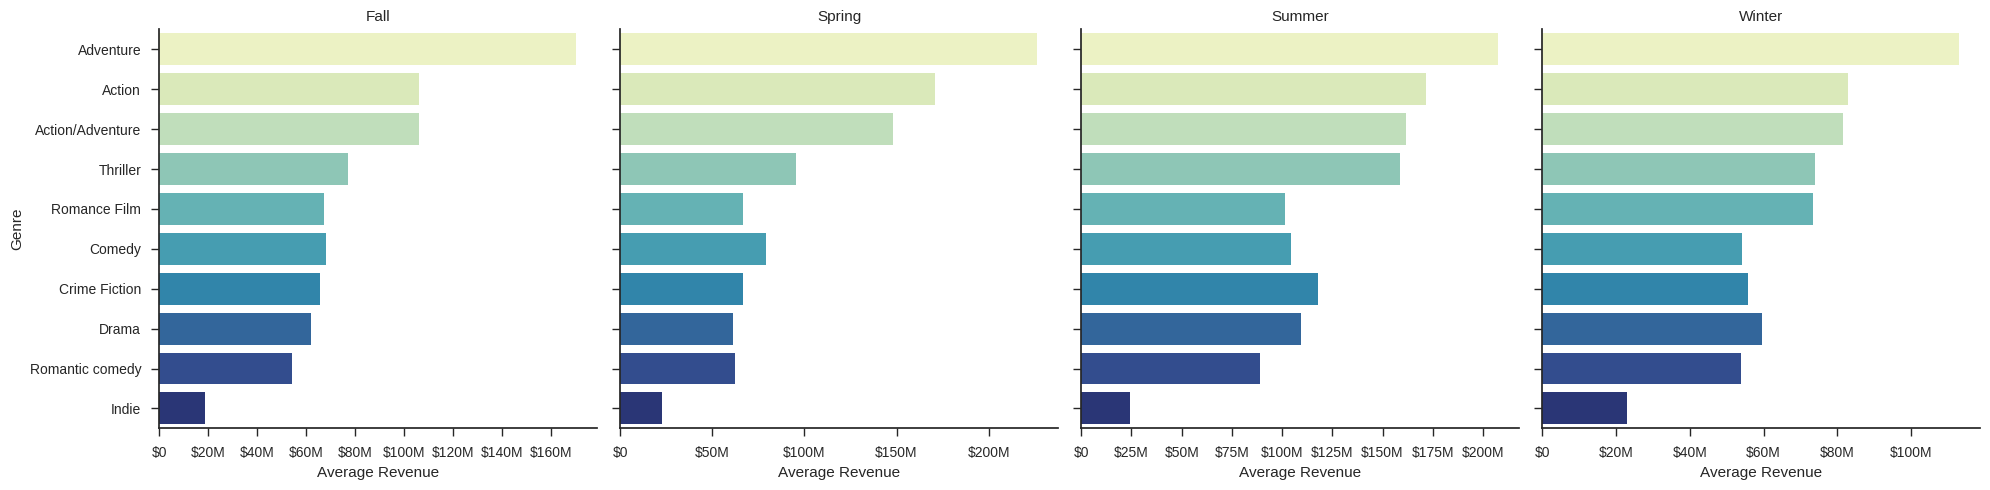

In [99]:
g = sns.FacetGrid(
    pivot_table_reset, col="Season", sharex=False, sharey=True, height=5, aspect=1
)
g.map_dataframe(
    sns.barplot,
    x="Average Revenue",
    y="movie_genres",
    order=sorted_genres,
    palette="YlGnBu",
)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Average Revenue", "Genre")
g.set(yticks=sorted_genres)

# Apply revenue_formatter to each subplot's x-axis
for ax in g.axes.flat:
    ax.xaxis.set_major_formatter(plt.FuncFormatter(revenue_formatter))

plt.tight_layout()
plt.show()

Alternative representation 3, disregarding thee frequency

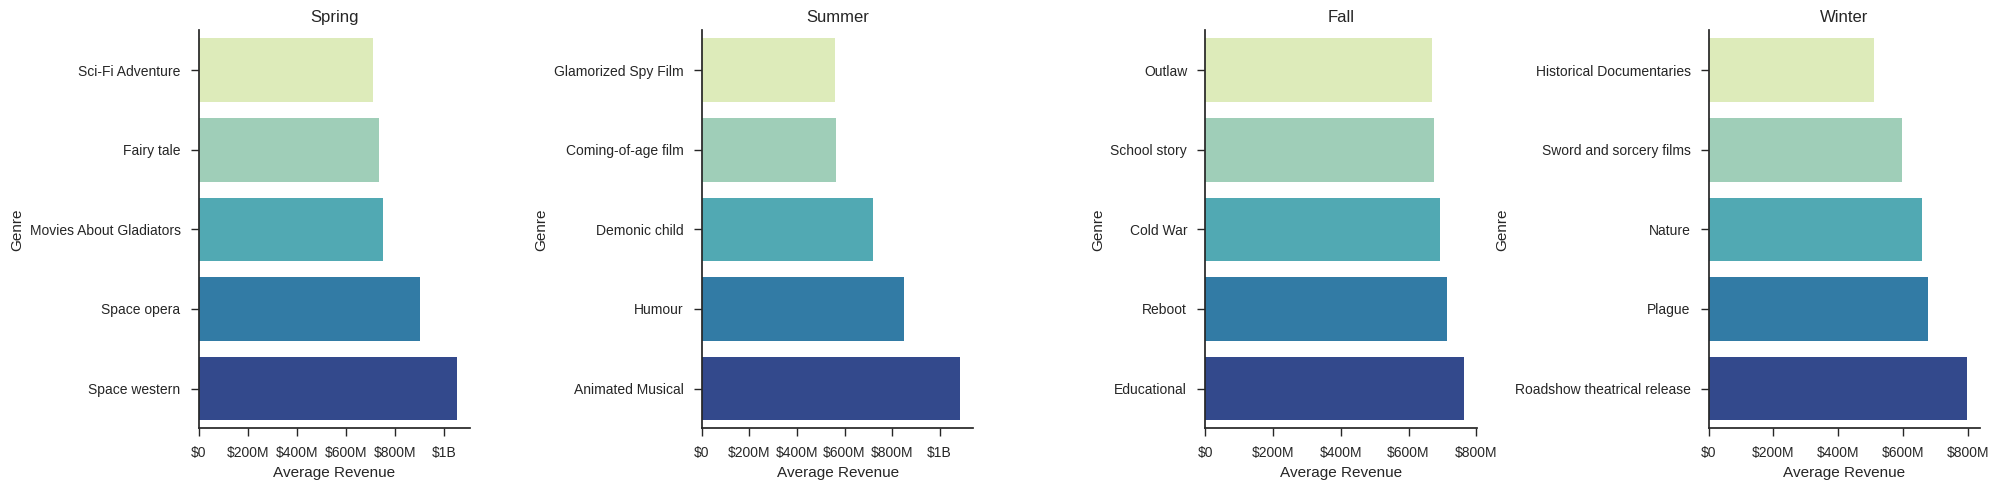

In [100]:
# Drop rows with missing values in 'season' or 'inflated_revenue'
df_genres_season = df_genres_and_season.dropna(subset=["season", "inflated_revenue"])

# Calculate average revenue per genre per season
genre_season_revenue = (
    df_genres_season.groupby(["season", "movie_genres"])["inflated_revenue"]
    .mean()
    .reset_index()
)

# Number of top genres to display per season
top_n = 5  # Adjust this number as needed

# Dictionary to store top genres per season
top_genres_per_season = {}

for season in genre_season_revenue["season"].unique():
    top_genres = (
        genre_season_revenue[genre_season_revenue["season"] == season]
        .sort_values("inflated_revenue", ascending=False)
        .head(top_n)["movie_genres"]
        .tolist()
    )
    top_genres_per_season[season] = top_genres

# Initialize an empty DataFrame to store filtered data
filtered_genre_season_revenue = pd.DataFrame()

# Loop through each season and filter the top genres
for season in top_genres_per_season:
    top_genres = top_genres_per_season[season]
    temp_df = genre_season_revenue[
        (genre_season_revenue["season"] == season)
        & (genre_season_revenue["movie_genres"].isin(top_genres))
    ]
    filtered_genre_season_revenue = pd.concat(
        [filtered_genre_season_revenue, temp_df], ignore_index=True
    )

# Rename columns for clarity
filtered_genre_season_revenue.rename(
    columns={
        "movie_genres": "Genre",
        "inflated_revenue": "Average Revenue",
        "season": "Season",
    },
    inplace=True,
)

# Set the order of seasons
season_order = ["Spring", "Summer", "Fall", "Winter"]

# Create the FacetGrid
g = sns.FacetGrid(
    filtered_genre_season_revenue,
    col="Season",
    col_order=season_order,
    sharex=False,
    sharey=False,
    height=5,
    aspect=1,
)

# Map the barplot onto the FacetGrid
g.map_dataframe(sns.barplot, x="Average Revenue", y="Genre", palette="YlGnBu")

# Adjust titles and labels
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Average Revenue", "Genre")

# Adjust y-ticks and sort data within each subplot
for ax, season in zip(g.axes.flat, season_order):
    # Get top genres for this season
    top_genres = top_genres_per_season.get(season, [])
    # Reverse the order for better visualization
    top_genres_reversed = list(reversed(top_genres))
    # Filter data for the current season
    data = filtered_genre_season_revenue[
        filtered_genre_season_revenue["Season"] == season
    ]
    # Sort data according to top genres
    data = data.set_index("Genre").loc[top_genres_reversed].reset_index()
    # Clear the axis and plot again
    ax.clear()
    sns.barplot(x="Average Revenue", y="Genre", data=data, palette="YlGnBu", ax=ax)
    ax.set_title(season)
    ax.set_xlabel("Average Revenue")
    ax.set_ylabel("Genre")

plt.tight_layout()

# Apply revenue_formatter to each subplot's x-axis
for ax in g.axes.flat:
    ax.xaxis.set_major_formatter(plt.FuncFormatter(revenue_formatter))

plt.show()

Revenue vs. Duration by Season

<Figure size 1000x600 with 0 Axes>

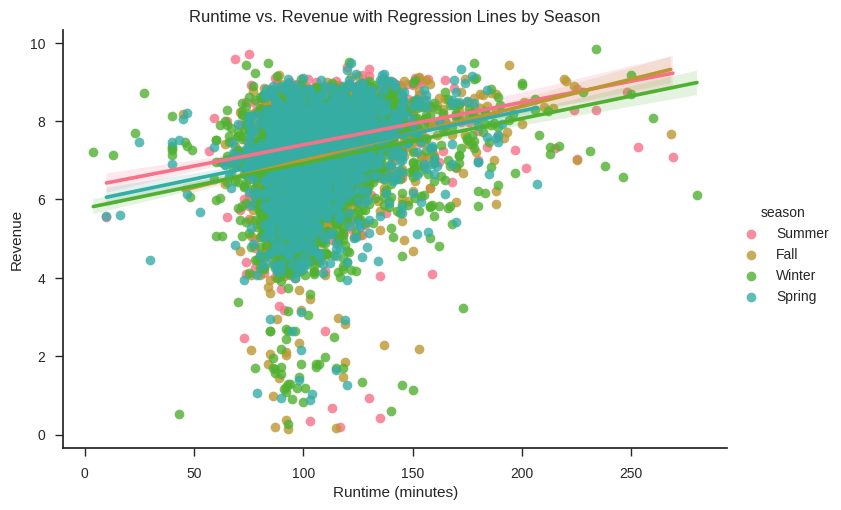

In [101]:
# filter the outlier movies with runtime > 300 minutes
# df_season_filtered = df_season[df_season["movie_runtime"] <= 300]

plt.figure(figsize=(10, 6))
sns.lmplot(
    x="movie_runtime",
    y="log_revenue",
    hue="season",
    data=df_season_filtered,
    aspect=1.5,
)
plt.title("Runtime vs. Revenue with Regression Lines by Season")
plt.xlabel("Runtime (minutes)")
plt.ylabel("Revenue")
plt.show()

The scatter plot shows the relationship between the movie runtime and the box office revenue, where the movies are categorized by the season in which they were released.
Regression lines are added for each season, showing the trend or slope for each season’s data points. The lines indicate if there is a positive, negative, or negligible correlation between runtime and revenue for each season.

Positive Slope: Implies that movies with longer runtimes tend to generate higher revenue in that season.

Negative Slope: Suggests that shorter movies tend to have higher revenue in that season.

Flat or Near-Zero Slope: Indicates little to no relationship between runtime and revenue for that season.

Movie revenue by the day of the week

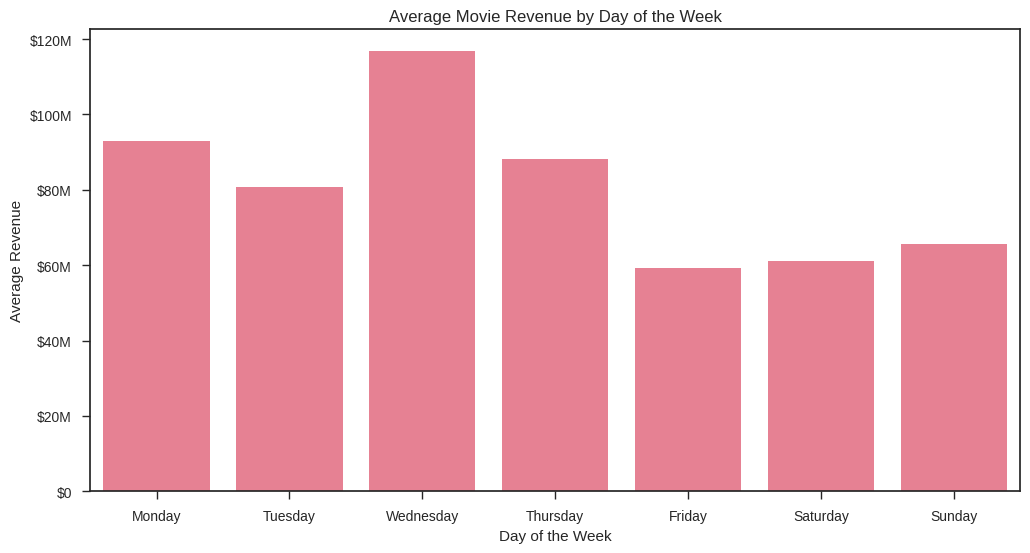

In [102]:
# Convert release date to datetime
df_season["movie_release_date"] = pd.to_datetime(
    df_season["movie_release_date"], errors="coerce"
)

# Extract day of the week
df_season["release_dayofweek"] = df_season["movie_release_date"].dt.day_name()

day_revenue = (
    df_season.groupby("release_dayofweek")["inflated_revenue"].mean().reset_index()
)
day_order = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]

plt.figure(figsize=(12, 6))
sns.barplot(
    x="release_dayofweek",
    y="inflated_revenue",
    data=day_revenue,
    order=day_order,
)
plt.title("Average Movie Revenue by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Average Revenue")
plt.gca().yaxis.set_major_formatter(revenue_formatter)
plt.show()

Heatmap of Genre Frequency by Year

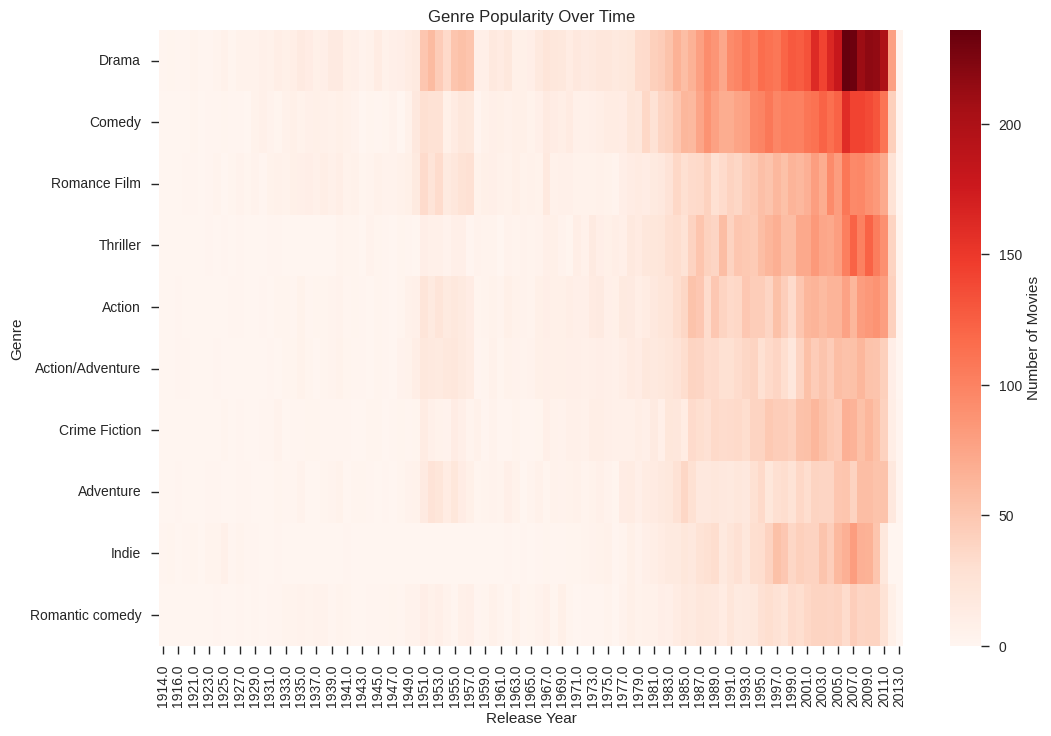

In [103]:
# Count of genres per year
genre_year = (
    df_genres_and_season.groupby(["movie_genres", "release_year"])
    .size()
    .reset_index(name="count")
)

# Pivot table
genre_year_pivot = genre_year.pivot_table(
    values="count", index="movie_genres", columns="release_year", fill_value=0
)

# Select top genres
top_genres_list = (
    df_genres_and_season["movie_genres"].value_counts().head(10).index.tolist()
)
genre_year_pivot = genre_year_pivot.loc[top_genres_list]

plt.figure(figsize=(12, 8))
sns.heatmap(genre_year_pivot, cmap="Reds", cbar_kws={"label": "Number of Movies"})
plt.title("Genre Popularity Over Time")
plt.xlabel("Release Year")
plt.ylabel("Genre")
plt.show()

Genre popularity by season

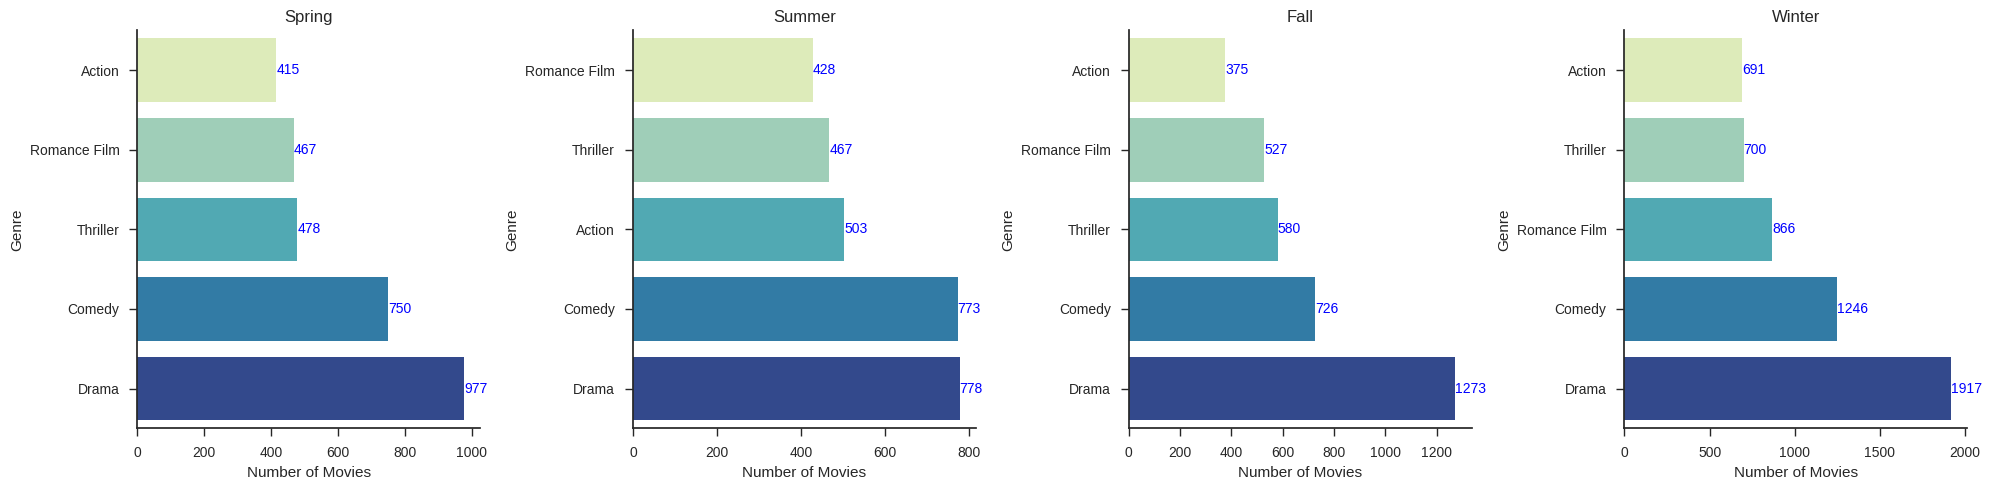

In [104]:
genre_season_count = (
    df_genres_and_season.groupby(["season", "movie_genres"])
    .size()
    .reset_index(name="movie_count")
)

# Number of top genres to display per season
top_n = 5  # Adjust this number as needed

# Dictionary to store top genres per season
top_genres_per_season = {}

for season in genre_season_count["season"].unique():
    top_genres = (
        genre_season_count[genre_season_count["season"] == season]
        .sort_values("movie_count", ascending=False)
        .head(top_n)["movie_genres"]
        .tolist()
    )
    top_genres_per_season[season] = top_genres


# Initialize an empty DataFrame to store filtered data
filtered_genre_season_count = pd.DataFrame()

# Loop through each season and filter the top genres
for season in top_genres_per_season:
    top_genres = top_genres_per_season[season]
    temp_df = genre_season_count[
        (genre_season_count["season"] == season)
        & (genre_season_count["movie_genres"].isin(top_genres))
    ]
    filtered_genre_season_count = pd.concat(
        [filtered_genre_season_count, temp_df], ignore_index=True
    )

# Rename columns for clarity
filtered_genre_season_count.rename(
    columns={"movie_genres": "Genre", "movie_count": "Movie Count", "season": "Season"},
    inplace=True,
)

# Set the order of seasons
season_order = ["Spring", "Summer", "Fall", "Winter"]

# Create the FacetGrid
g = sns.FacetGrid(
    filtered_genre_season_count,
    col="Season",
    col_order=season_order,
    sharex=False,
    sharey=False,
    height=5,
    aspect=1,
)

# Adjust y-ticks and plot data
for ax, season in zip(g.axes.flat, season_order):
    # Get data for the current season
    data = filtered_genre_season_count[filtered_genre_season_count["Season"] == season]
    # Get top genres and reverse for better visualization
    top_genres = list(reversed(top_genres_per_season.get(season, [])))
    # Sort data accordingly
    data = data.set_index("Genre").loc[top_genres].reset_index()
    # Plot
    sns.barplot(x="Movie Count", y="Genre", data=data, palette="YlGnBu", ax=ax)
    ax.set_title(season)
    ax.set_xlabel("Number of Movies")
    ax.set_ylabel("Genre")

    # Adjust y-ticks
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    # Display values on bars
    for i, v in enumerate(data["Movie Count"]):
        ax.text(v + 0.1, i, str(int(v)), color="blue", va="center")

plt.tight_layout()
plt.show()

Alternative representation

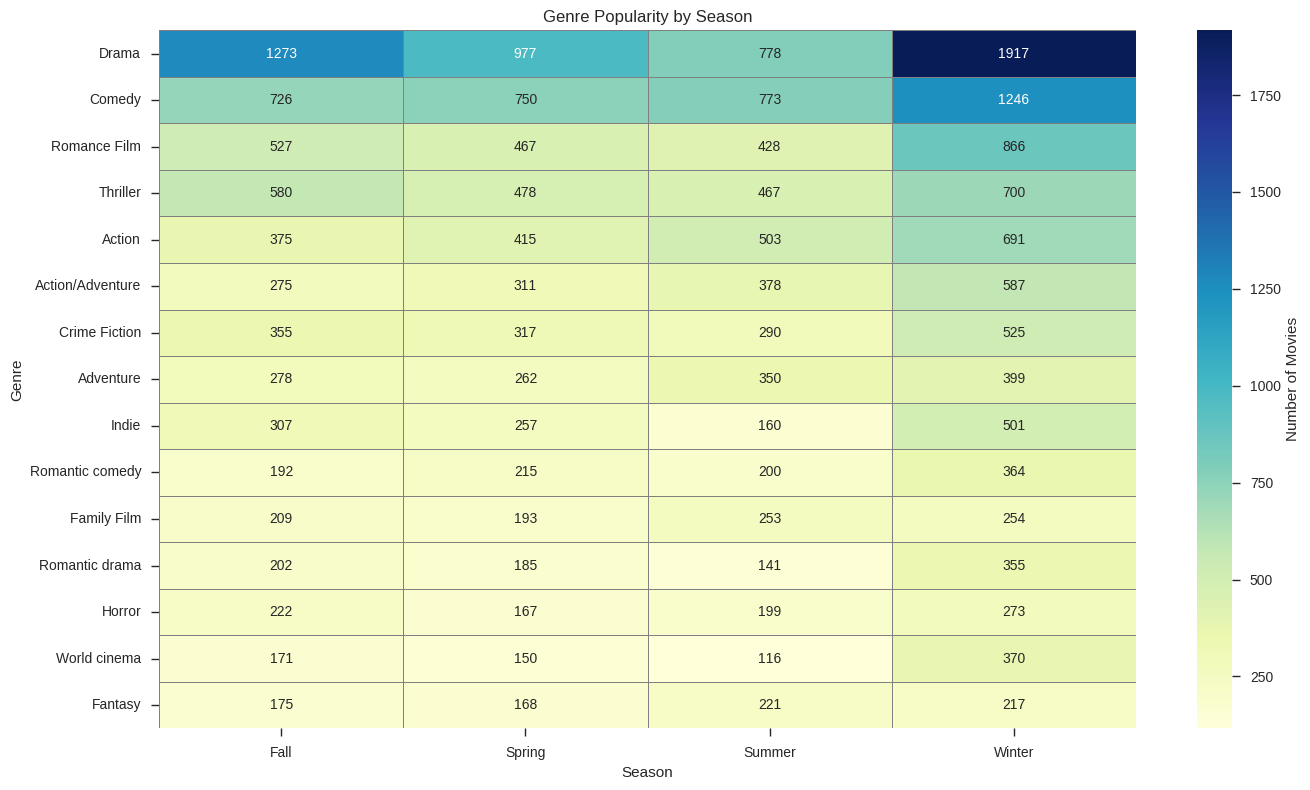

In [105]:
# Create pivot table
pivot_table = genre_season_count.pivot_table(
    values="movie_count",
    index="movie_genres",
    columns="season",
    aggfunc="sum",
    fill_value=0,
)

# Select top genres overall
top_genres_overall = (
    df_genres_and_season["movie_genres"].value_counts().head(15).index.tolist()
)
pivot_table = pivot_table.loc[top_genres_overall]

plt.figure(figsize=(14, 8))
sns.heatmap(
    pivot_table,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={"label": "Number of Movies"},
)
plt.title("Genre Popularity by Season")
plt.xlabel("Season")
plt.ylabel("Genre")
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - Drama movies are popular in all seasons. 

</div>

#### ANOVA for Seasons

<div class="alert alert-success">

  💭 <strong>Idea:</strong>
  - How do the revenue distributions look like based on seasons or genre?
  
</div>
<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>
  - ANOVA analysis, box plots

</div>

In [106]:
# Convert the string representation to an actual list
df_season["movie_genres"] = df_season["movie_genres"].apply(ast.literal_eval)

# Extract genre names
df_season["movie_genres"] = df_season["movie_genres"].apply(
    lambda x: [genre[1] for genre in x]
)

# For simplicity, we'll focus on the primary genre (first in the list)
df_season["primary_genre"] = df_season["movie_genres"].apply(
    lambda x: x[0] if len(x) > 0 else np.nan
)

# Drop rows with missing primary genre
df_season = df_season.dropna(subset=["primary_genre"])

In [107]:
# Create a list of revenues for each season
season_revenues = [
    df_season[df_season["season"] == season]["inflated_revenue"]
    for season in df_season["season"].unique()
]

# Perform one-way ANOVA
F_statistic, p_value = f_oneway(*season_revenues)

print("ANOVA Results for Seasons:")
print("F-statistic:", F_statistic)
print("p-value:", p_value)

ANOVA Results for Seasons:
F-statistic: 34.0916292738672
p-value: 6.608581196787151e-22


With reduced complexity


ANOVA Results for Genres:
F-statistic: 25.716342276124497
p-value: 4.208199908675079e-21


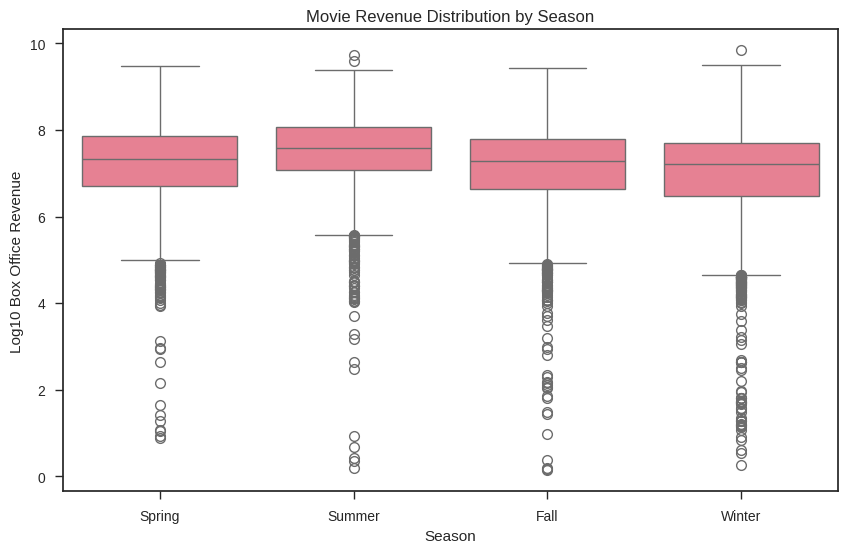

In [ ]:
# Consider top N genres to reduce complexity
top_genres = df_season["primary_genre"].value_counts().head(5).index.tolist()
df_top_genres = df_season[df_season["primary_genre"].isin(top_genres)]

# Create a list of revenues for each genre
genre_revenues = [
    df_top_genres[df_top_genres["primary_genre"] == genre]["inflated_revenue"]
    for genre in top_genres
]

# Perform one-way ANOVA
F_statistic, p_value = f_oneway(*genre_revenues)

print("\nANOVA Results for Genres:")
print("F-statistic:", F_statistic)
print("p-value:", p_value)

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="season",
    y="log_revenue",  # Use log scale if the revenue distribution is highly skewed
    data=df_season,
    order=["Spring", "Summer", "Fall", "Winter"],
)
plt.title("Movie Revenue Distribution by Season")
plt.xlabel("Season")
plt.ylabel("Log10 Box Office Revenue")
plt.show()

Boxplot of Revenue by Season

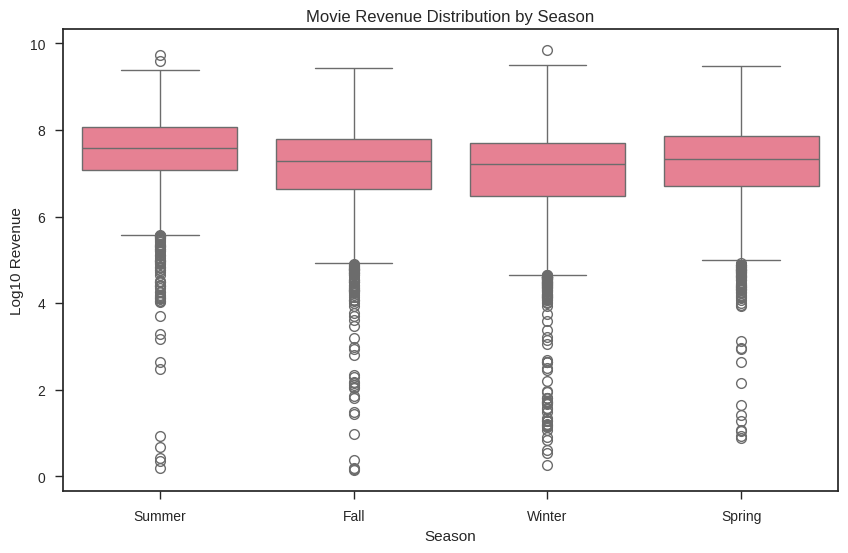

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="season", y="log_revenue", data=df_season)
plt.title("Movie Revenue Distribution by Season")
plt.xlabel("Season")
plt.ylabel("Log10 Revenue")
plt.show()

Boxplot of Revenue by Genre

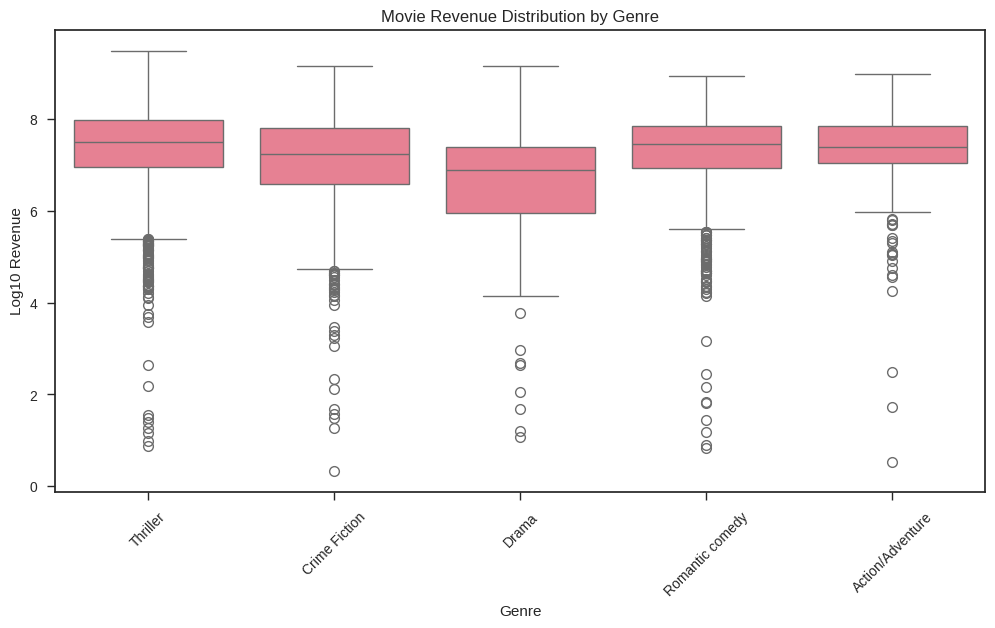

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="primary_genre", y="log_revenue", data=df_top_genres)
plt.title("Movie Revenue Distribution by Genre")
plt.xlabel("Genre")
plt.ylabel("Log10 Revenue")
plt.xticks(rotation=45)
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

   - Initial observations show that summer season, and thriller and adventure movies have the highest revenues.

</div>